### Importa librerie e carica dati 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import geopandas as gpd
import folium
import time
from pandas.plotting import lag_plot

# carica dati 
#data = pd.read_csv('timeseries/AereoportoBLQ_20170416_20170817', 
#                   header = None, names=['date', 'cell_num', 'nr_people'], index_col = None)
data = pd.read_csv('/Users/alket/Desktop/poliseye_timeseries/data/new_data_backfill_forwfill.csv', index_col = 0)

/Users/alket/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
data.head()

date  cell_num  nr_people  hours  minutes
0    2017-04-16  486-1252       36.0    0.0      0.0
221  2017-04-16  486-1252       36.0    0.0     15.0
442  2017-04-16  486-1252       34.0    0.0     30.0
663  2017-04-16  486-1252       33.0    0.0     45.0
884  2017-04-16  486-1252       32.0    1.0      0.0

In [4]:
data.describe()

nr_people         hours       minutes
count  2.609568e+06  2.609568e+06  2.609568e+06
mean   1.504546e+02  1.150000e+01  2.250000e+01
std    1.801338e+02  6.922188e+00  1.677051e+01
min    8.000000e+00  0.000000e+00  0.000000e+00
25%    3.400000e+01  5.750000e+00  1.125000e+01
50%    7.700000e+01  1.150000e+01  2.250000e+01
75%    2.110000e+02  1.725000e+01  3.375000e+01
max    2.230000e+03  2.300000e+01  4.500000e+01

### Funzioni di creazione nuove features

In [5]:
# crea un campo 'is_business_day' con valore binario
business_day = []

def find_business_days(business_day):
    for i in data.date:
        #print(i)
        s = i.split('-')
        year = int(s[0])
       # print(year, '----------------_>>>>><')
        month = int(s[1])
        day = int(s[2])
        ##print(day, ' ', month, ' ', year)
    
        dayofweek = datetime.date(year, month, day).strftime("%A")
        if ((dayofweek == 'Saturday') | (dayofweek == 'Sunday')): 
            business_day.append(0)
        else: 
            business_day.append(1)
     
    return business_day

bd = find_business_days(business_day)
data['is_business_day']= bd      

business_h = []
def find_business_hours(business_h):
    for i in data['hours']:
        if i > 8 and i < 18 :
            business_h.append(1)
        
        else:
            business_h.append(0)
    return business_h  

business_h = find_business_hours(business_h)        
data['is_business_hour'] = business_h

In [6]:
data.head()

date  cell_num  nr_people  hours  minutes  is_business_day  \
0    2017-04-16  486-1252       36.0    0.0      0.0                0   
221  2017-04-16  486-1252       36.0    0.0     15.0                0   
442  2017-04-16  486-1252       34.0    0.0     30.0                0   
663  2017-04-16  486-1252       33.0    0.0     45.0                0   
884  2017-04-16  486-1252       32.0    1.0      0.0                0   

     is_business_hour  
0                   0  
221                 0  
442                 0  
663                 0  
884                 0

### Aggregazione e visualizzazione dati

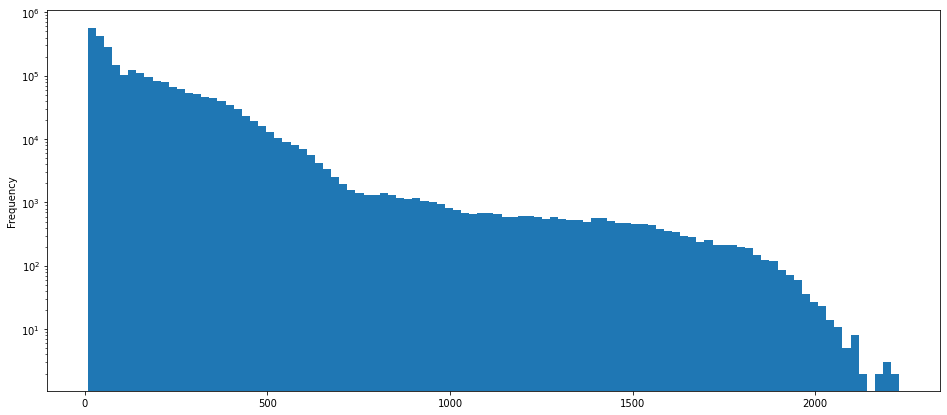

In [7]:
# histogramma della distribuzione dei valori cella (nr_persone) in scala logaritmica 
data['nr_people'].plot(kind = 'hist', figsize = (16, 7), bins = 100, log = True);

In [8]:
# trova le osservazioni fatte nelle ore lavorative e in quelle non lavorative 
bh = data[data['is_business_hour']==1]
no_bh = data[data['is_business_hour']==0]
b_hours = bh['nr_people'].to_numpy()
no_b_hours = no_bh['nr_people'].to_numpy()

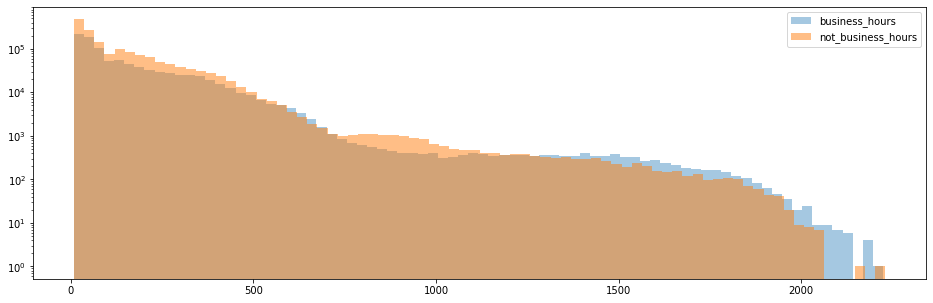

In [9]:
plt.figure(figsize=(16,5))
plt.hist(b_hours, 80, alpha= 0.4, label = 'business_hours', log = True)
plt.hist(no_b_hours, 80, alpha= 0.5, label = 'not_business_hours', log = True)
plt.legend(loc='upper right')
plt.show()

In [10]:
# trova le osservazioni fatte nelle ore lavorative e in quelle non lavorative 
bday = data[data['is_business_day']==1]
no_bday = data[data['is_business_day']==0]
b_nr_people = bday['nr_people'].to_numpy()
no_b_nr_people = no_bday['nr_people'].to_numpy()

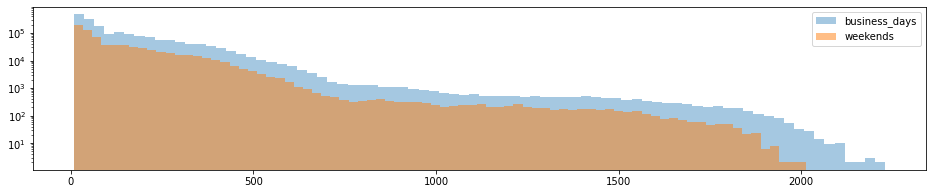

In [11]:
plt.figure(figsize=(16,3))
plt.hist(b_nr_people, 80, alpha= 0.4, label = 'business_days', log = True)
plt.hist(no_b_nr_people, 80, alpha= 0.5, label = 'weekends', log = True)
plt.legend(loc='upper right')
plt.show()

In [12]:
agg_by_date = data.groupby(by = ['date'])
print(len(agg_by_date), 'giorni')

agg_by_cell = data.groupby(by = ['cell_num'])
print(len(agg_by_cell), 'celle')

agg_by_hour = data.groupby(by = ['hours'])
print(len(agg_by_hour), 'ore')

agg_by_date_cell = data.groupby(by = ['date','cell_num']) 
print(len(agg_by_date_cell), ' = 123 giorni x 221 celle')

agg_by_date_hour = data.groupby(by = ['date', 'hours'])
print(len(agg_by_date_hour), ' = 123 giorni x 24 ore')

agg_by_cell_hour = data.groupby(by = ['cell_num', 'hours'])
print(len(agg_by_cell_hour), ' = 221 celle x 24 ore')

123 giorni
221 celle
24 ore
27183  = 123 giorni x 221 celle
2952  = 123 giorni x 24 ore
5304  = 221 celle x 24 ore


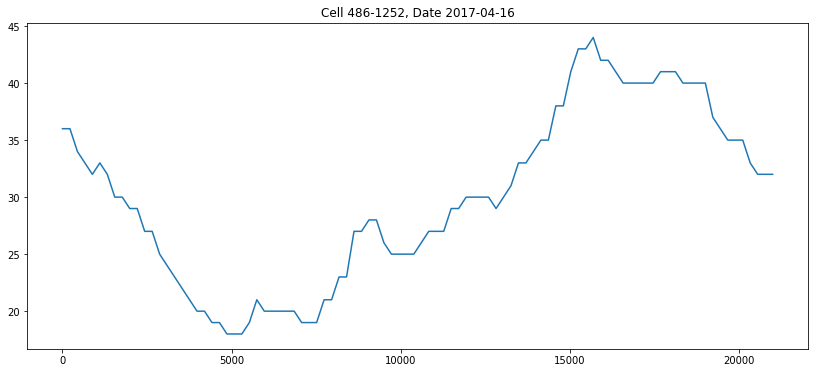

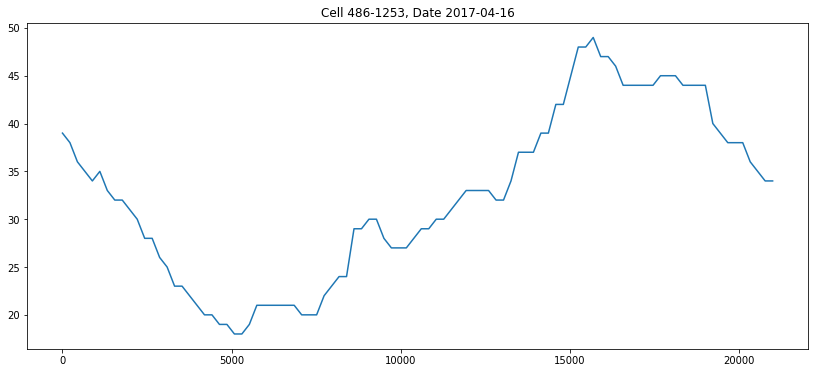

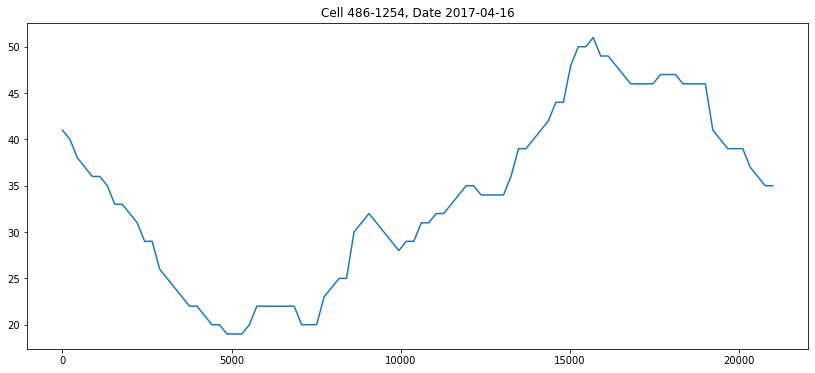

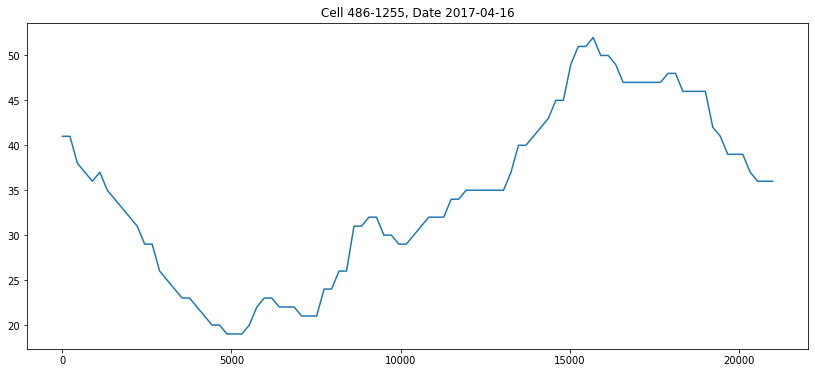

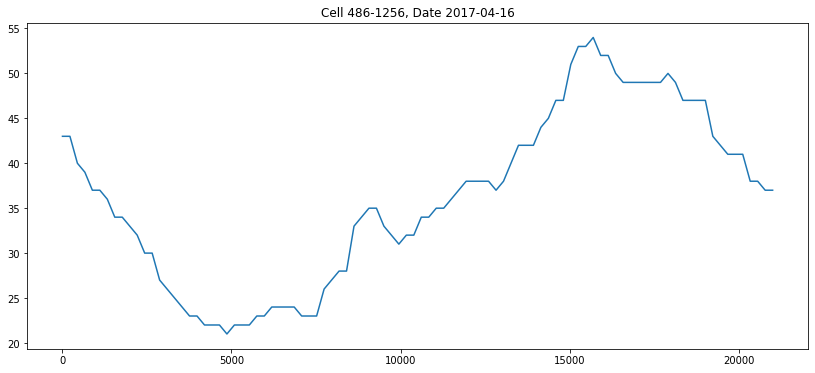

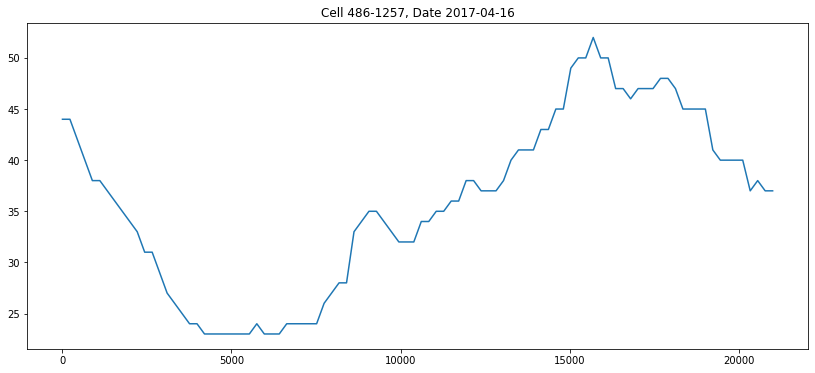

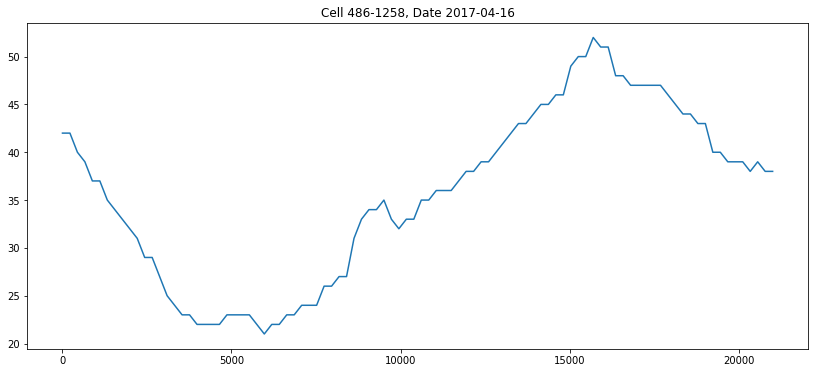

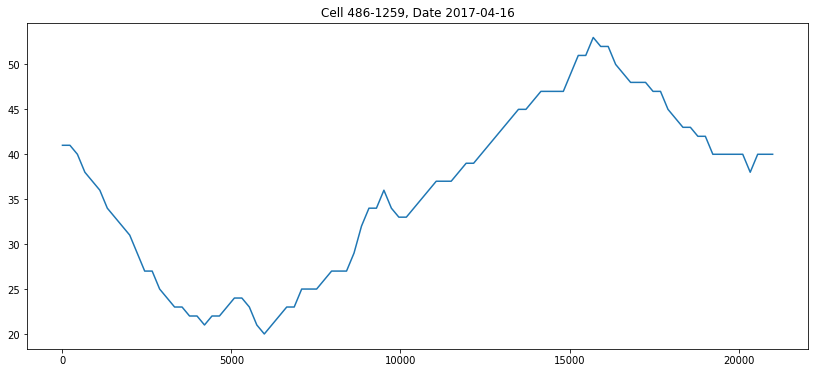

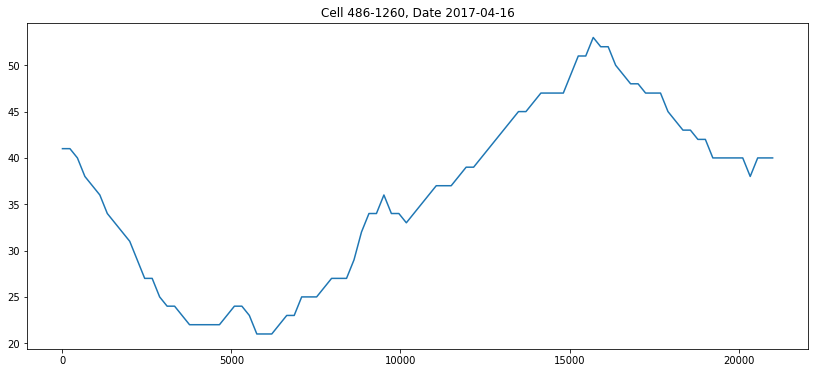

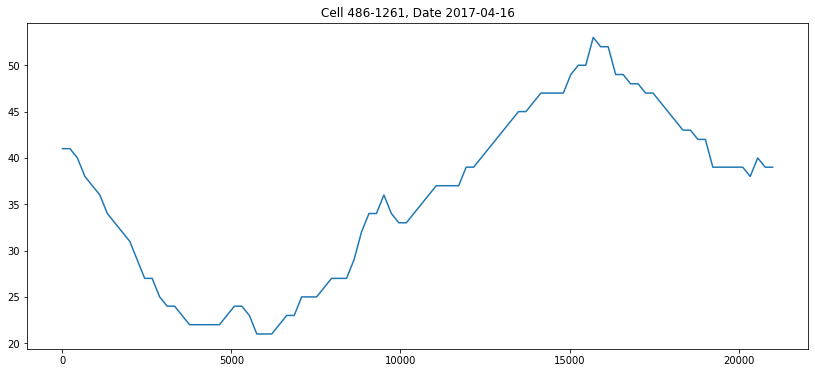

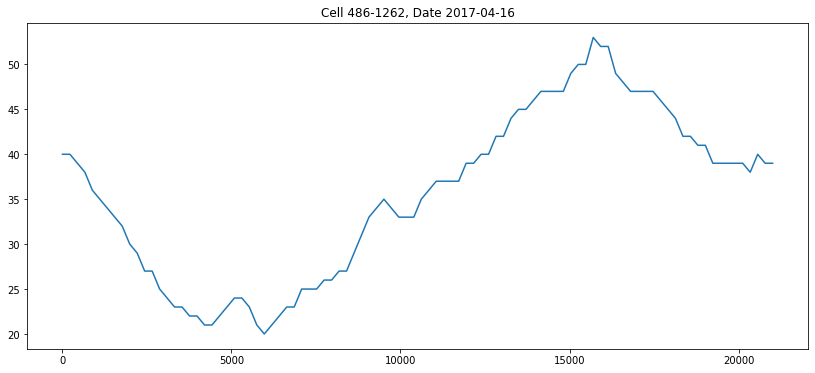

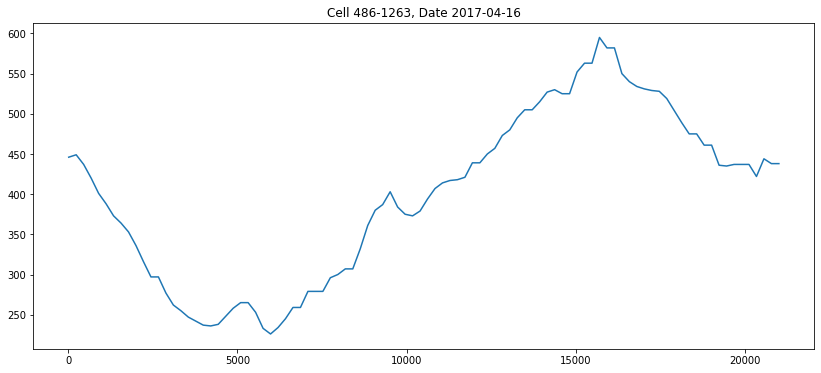

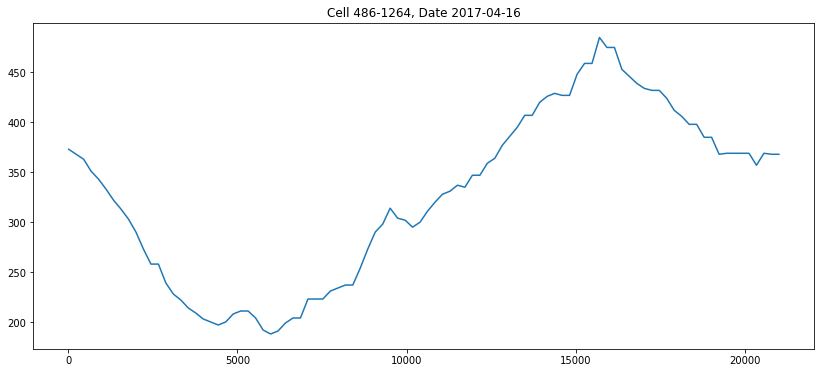

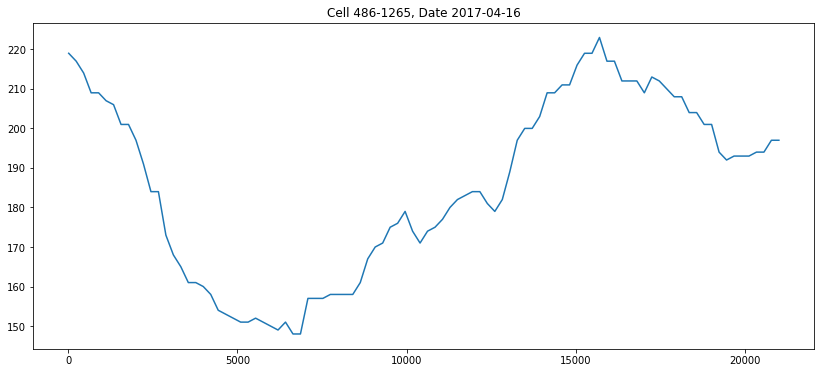

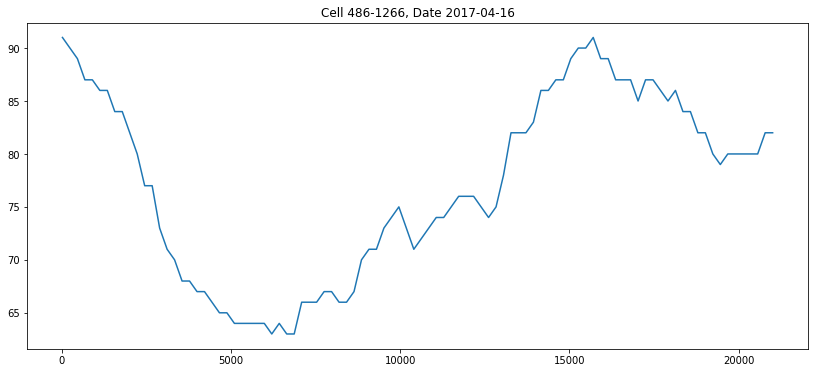

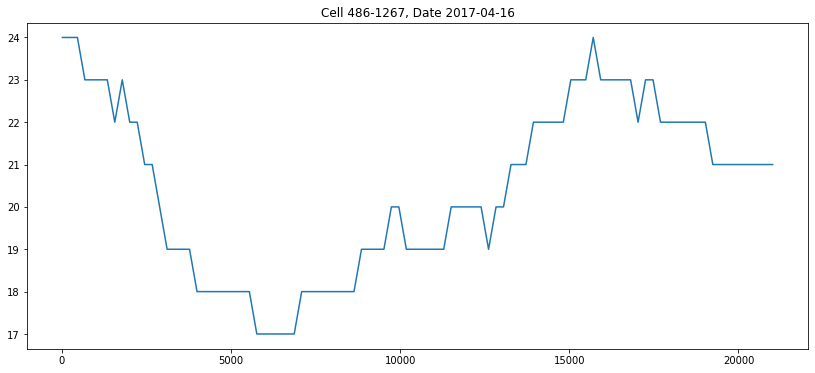

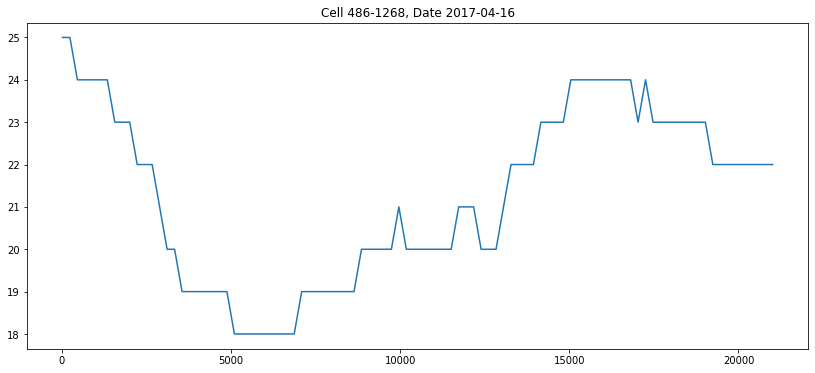

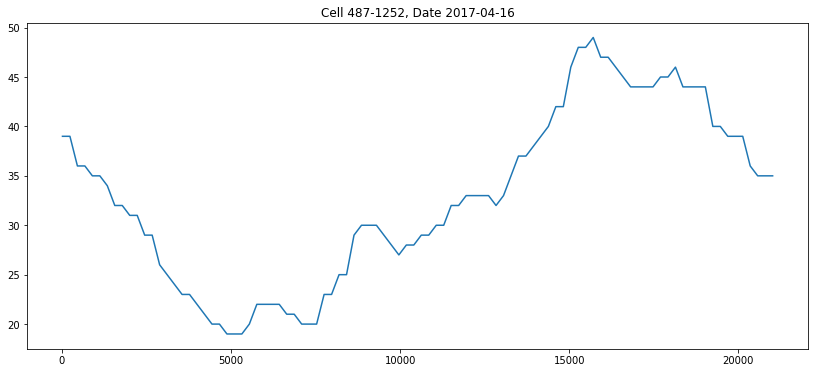

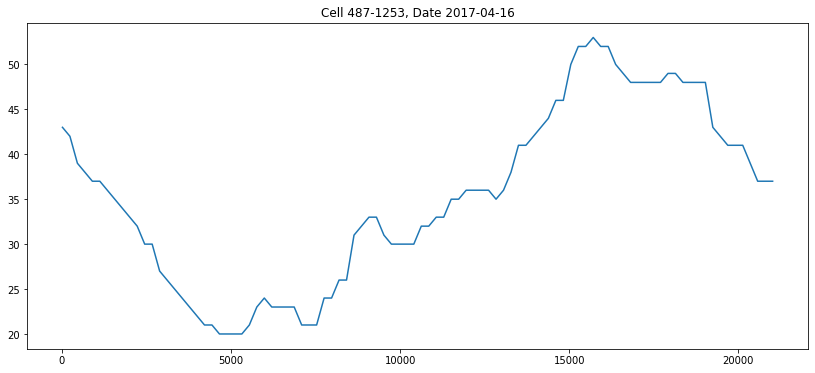

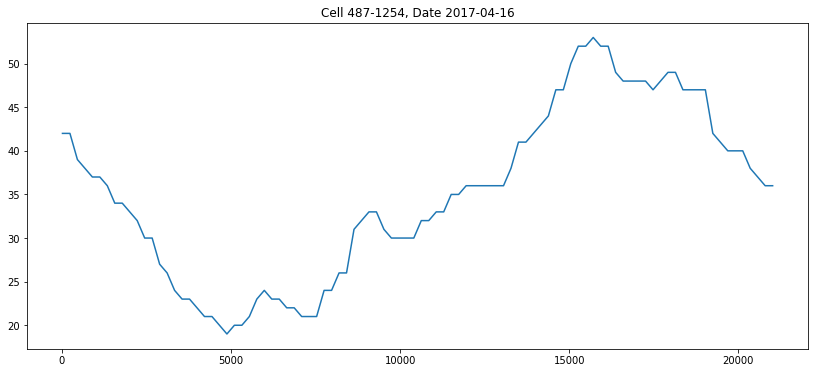

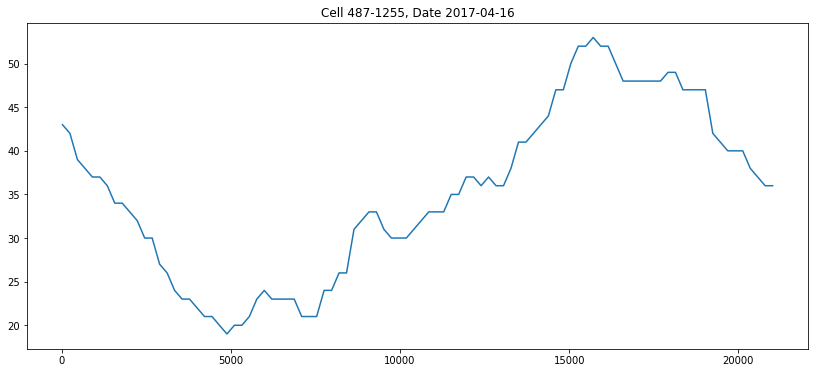

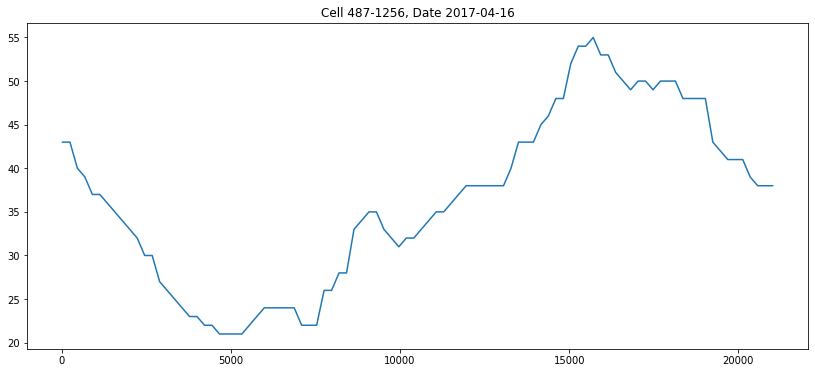

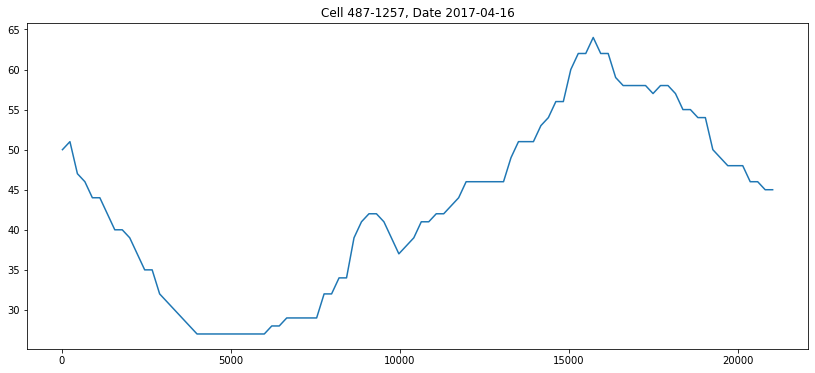

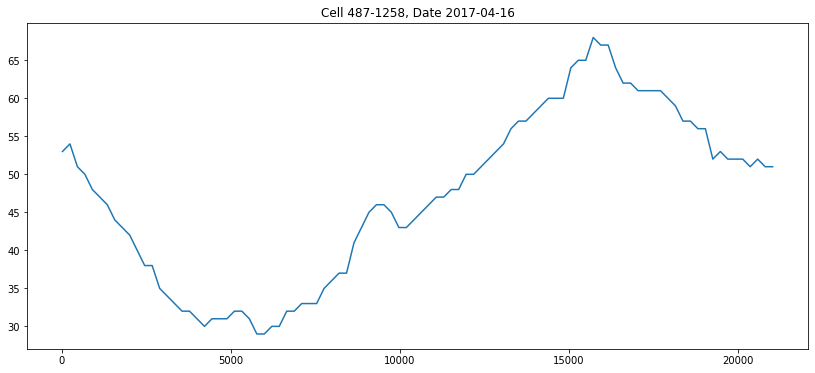

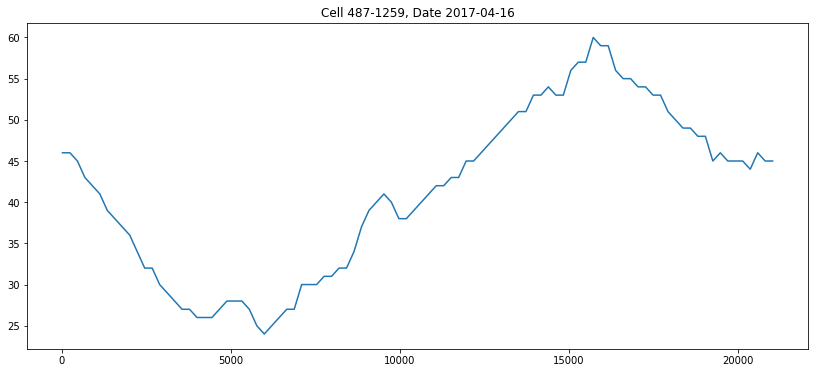

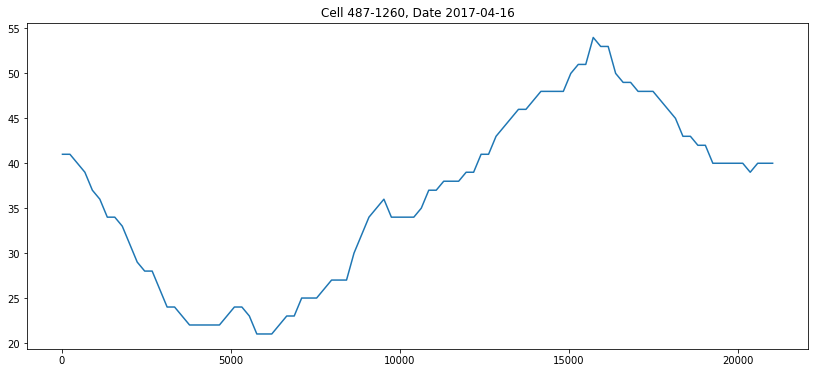

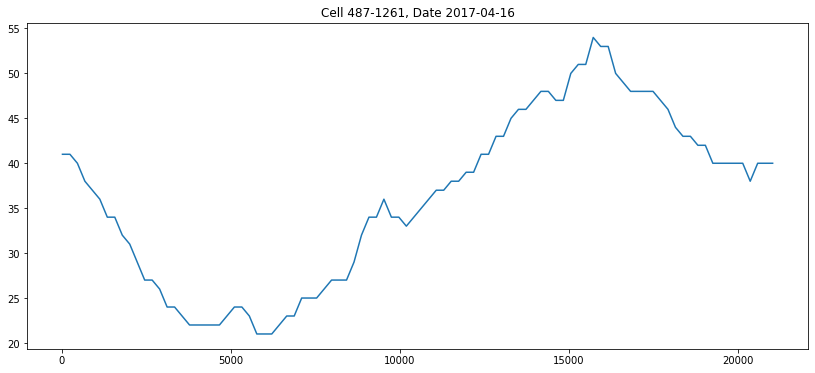

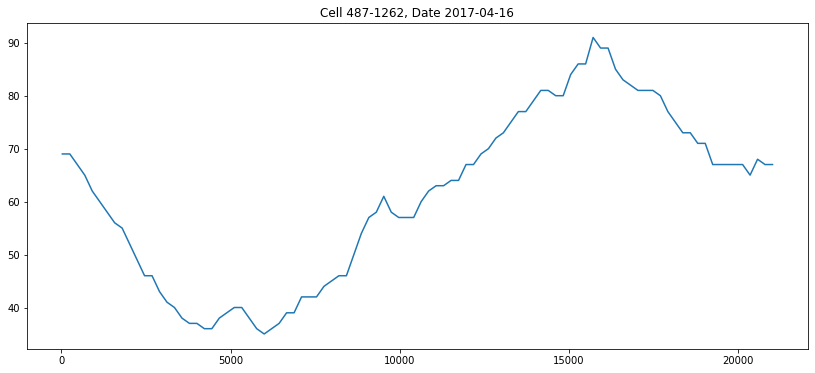

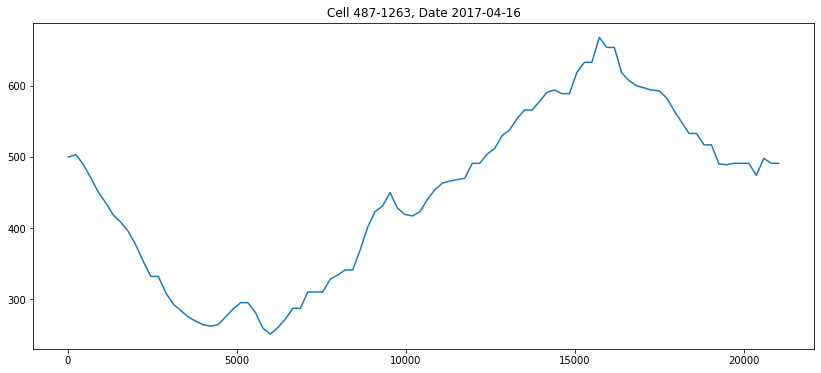

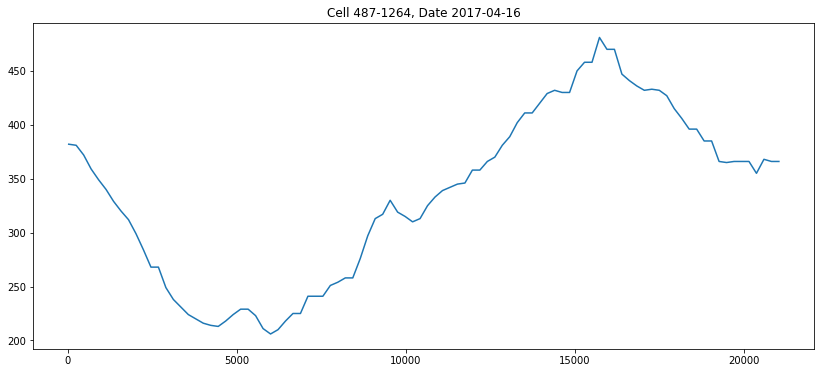

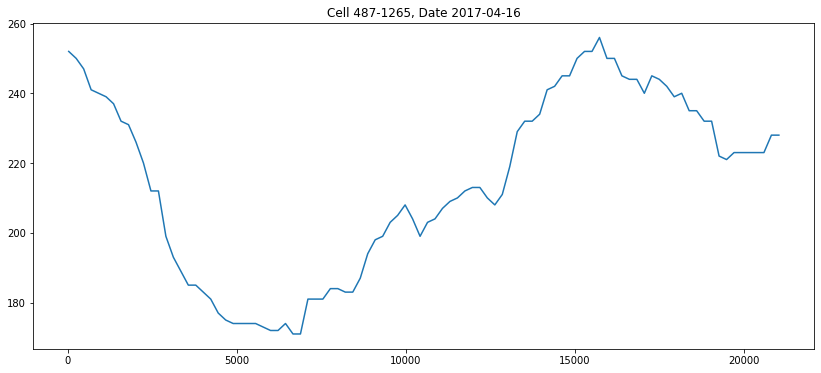

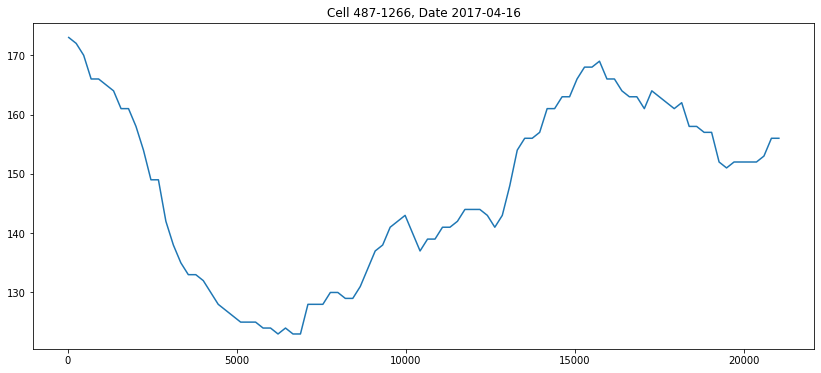

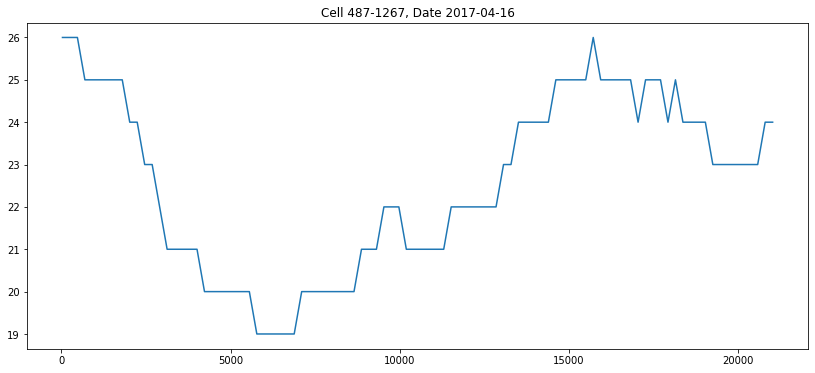

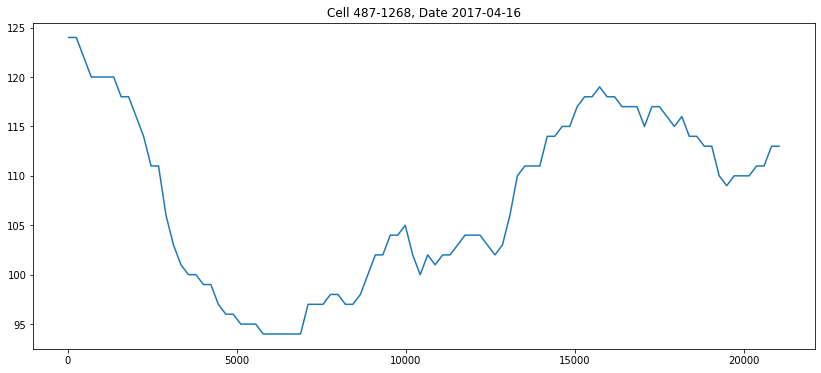

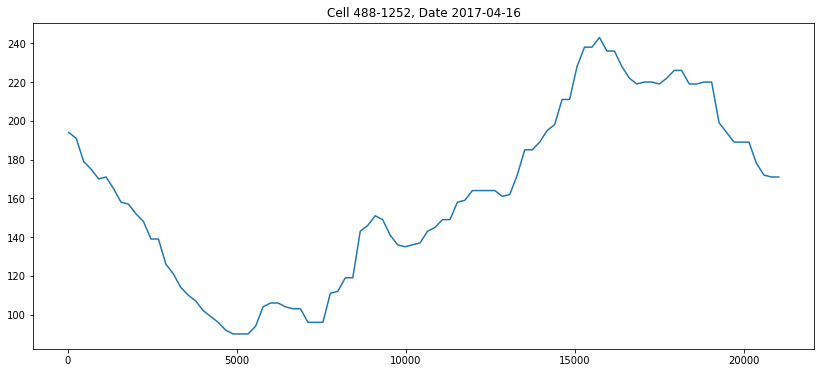

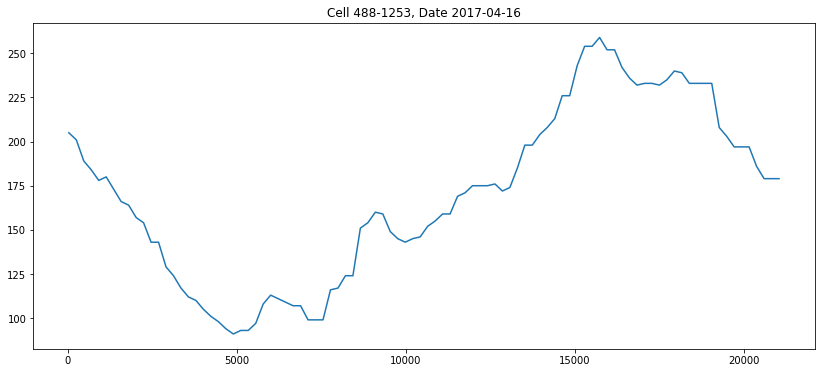

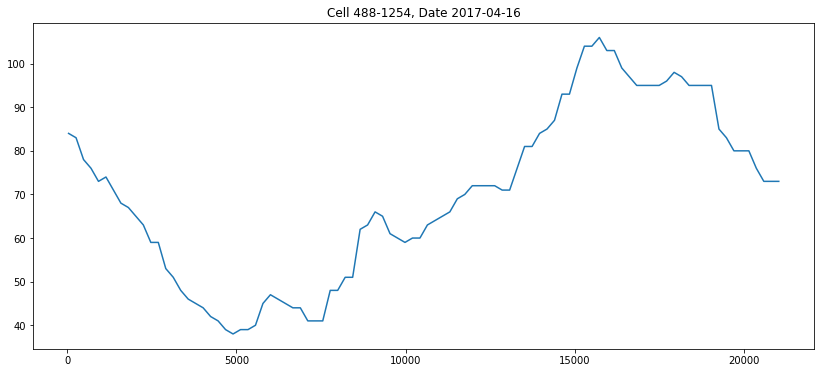

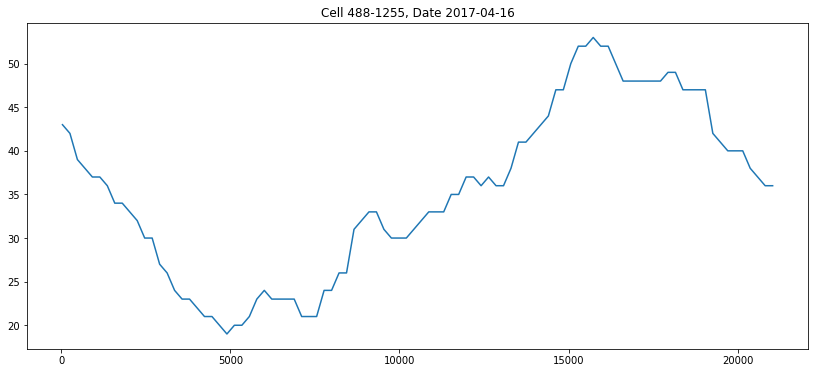

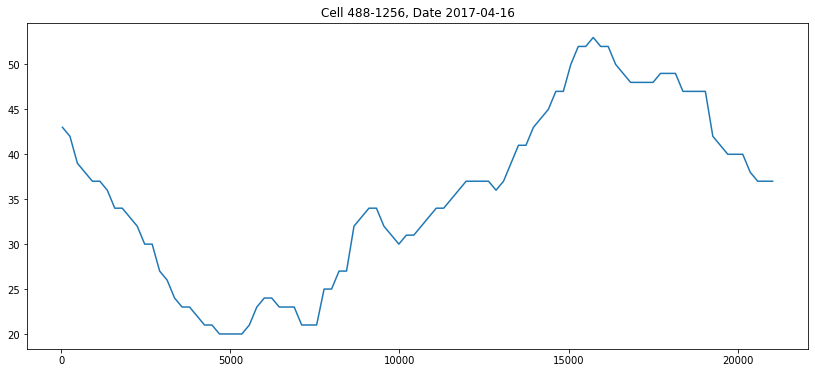

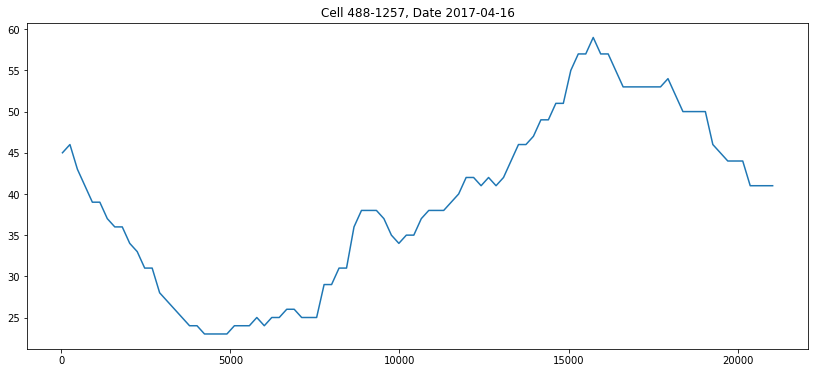

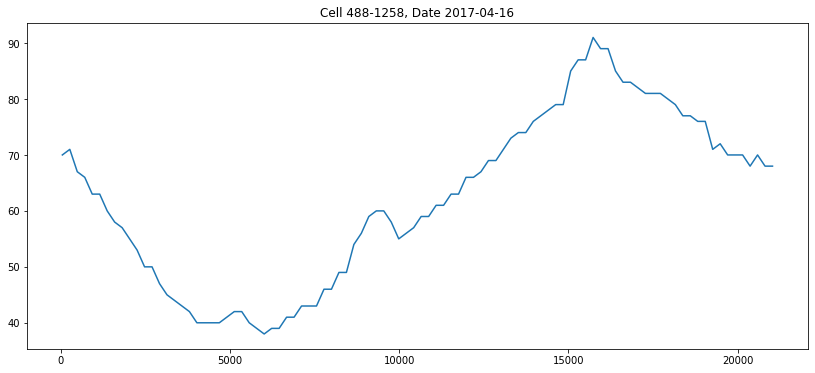

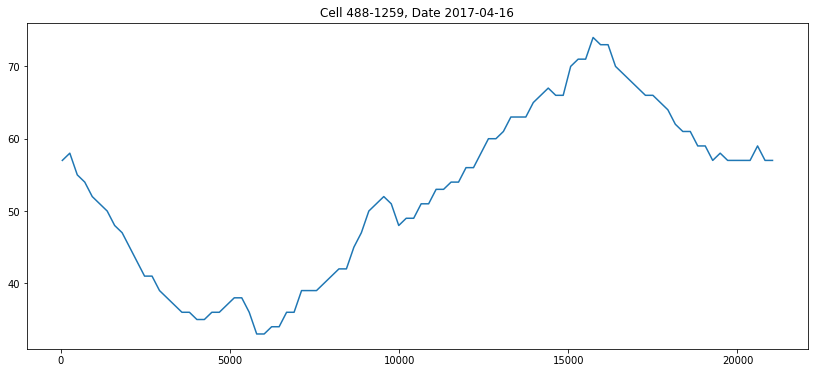

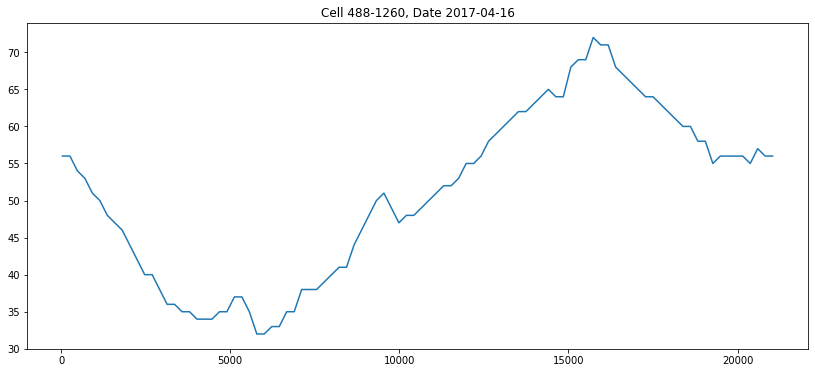

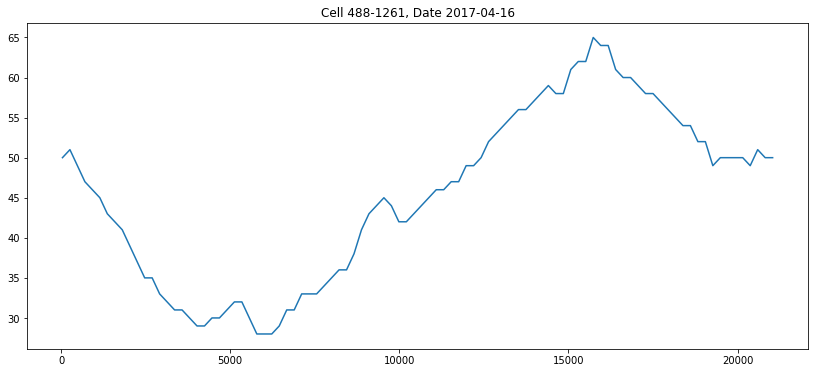

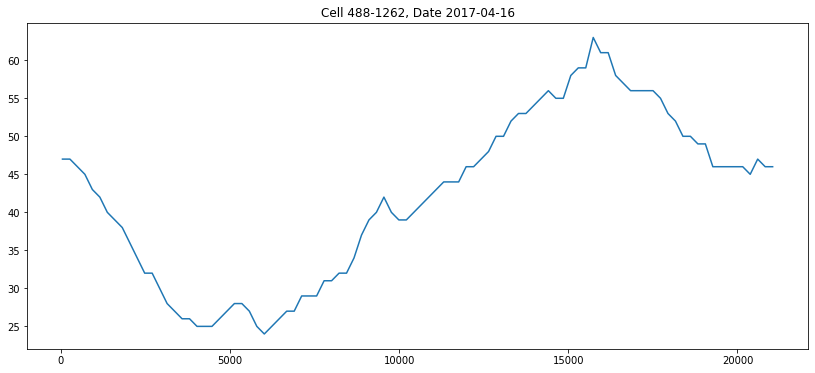

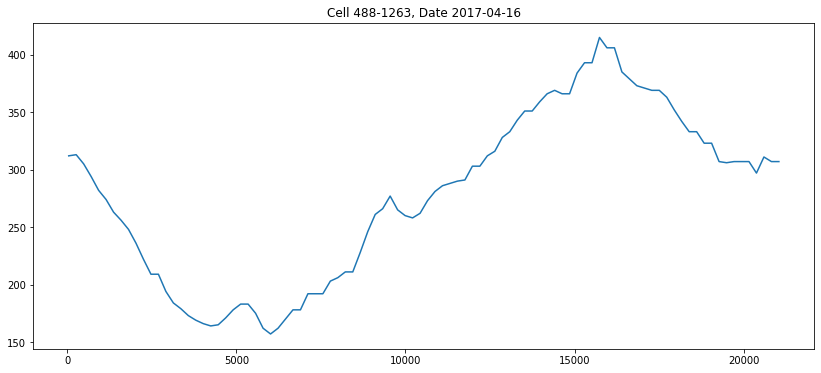

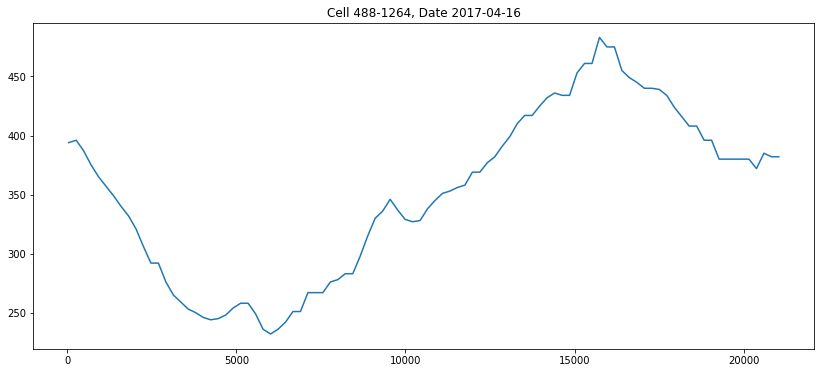

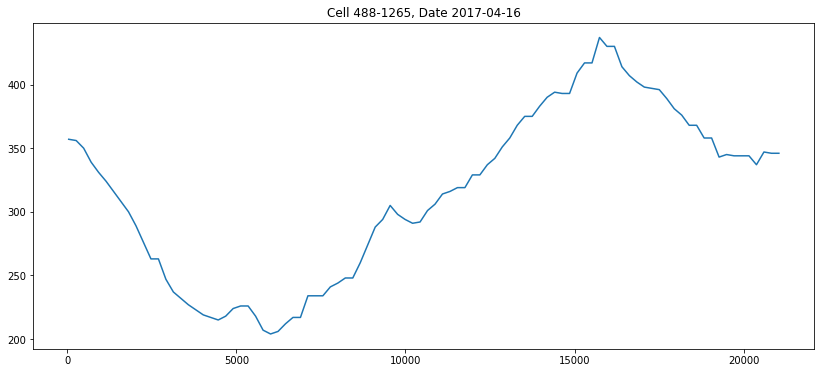

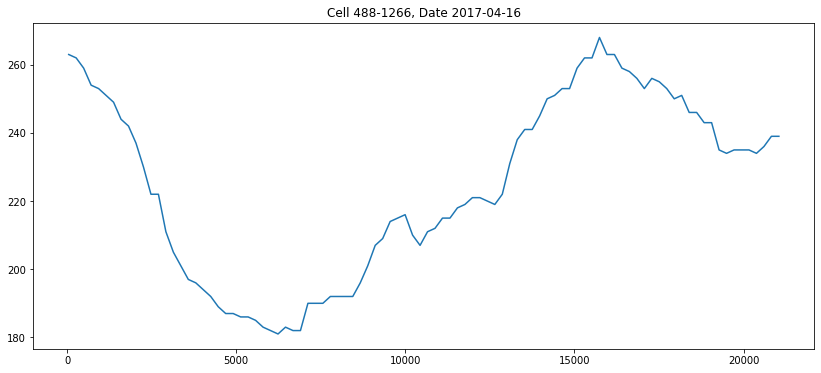

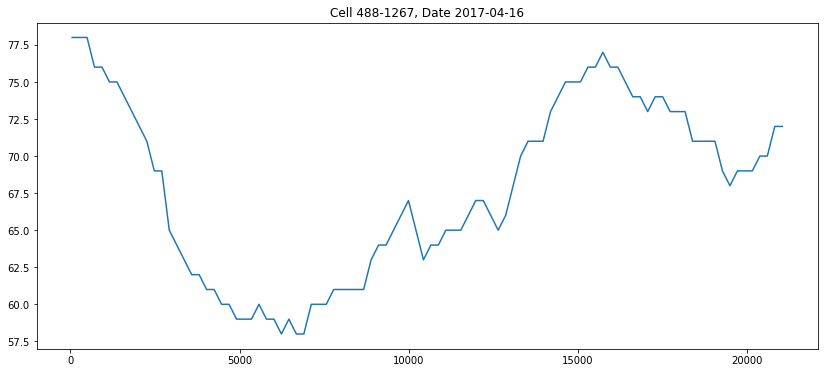

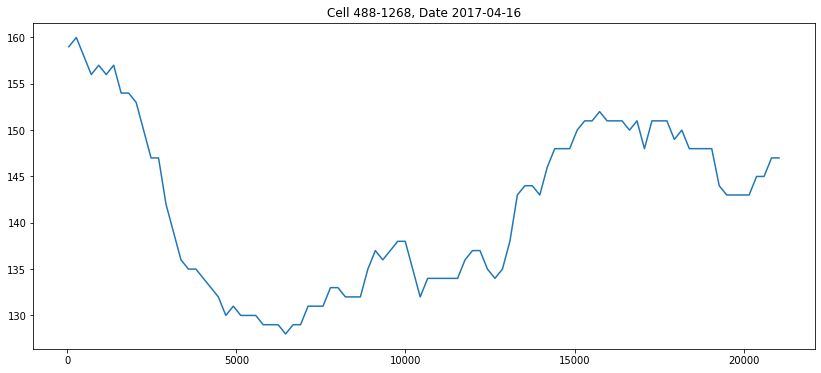

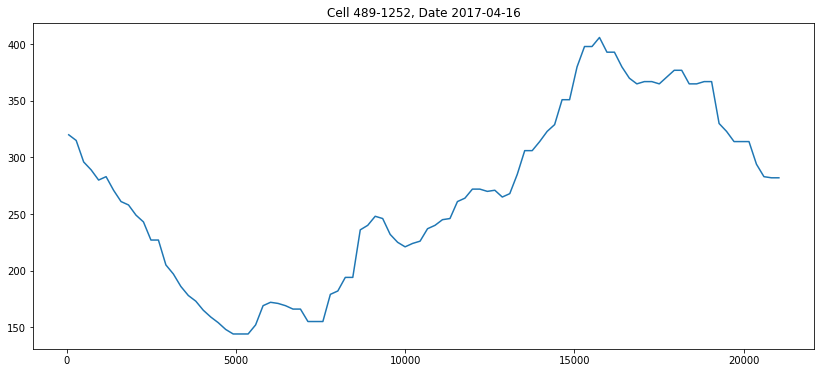

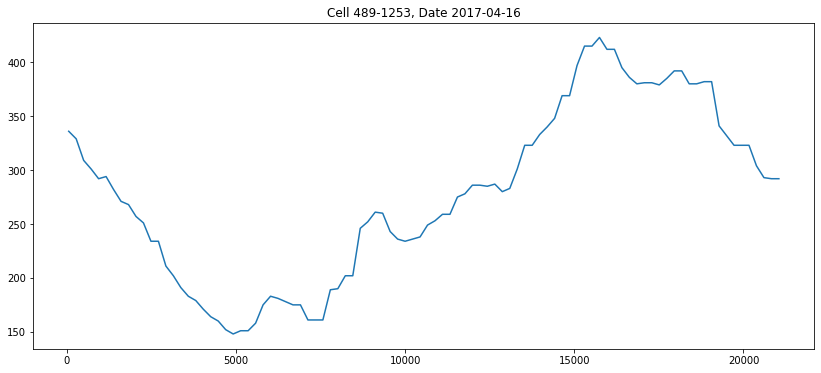

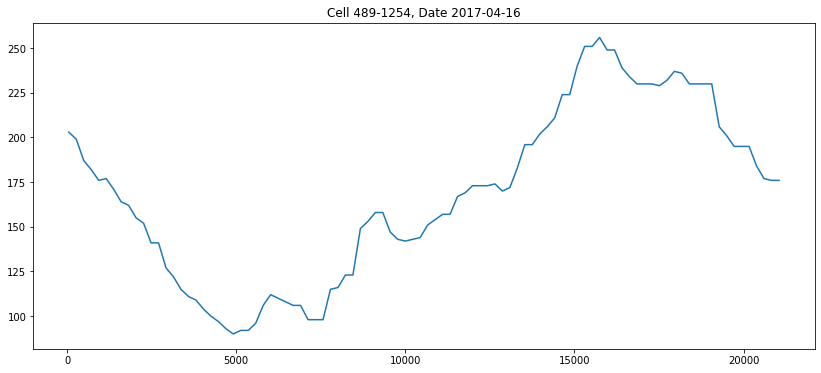

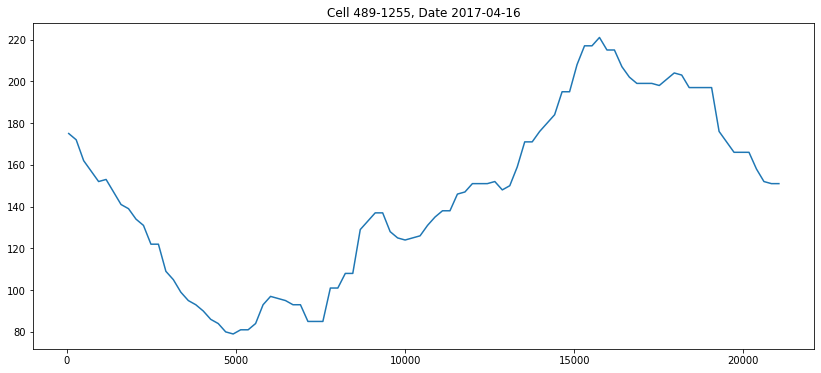

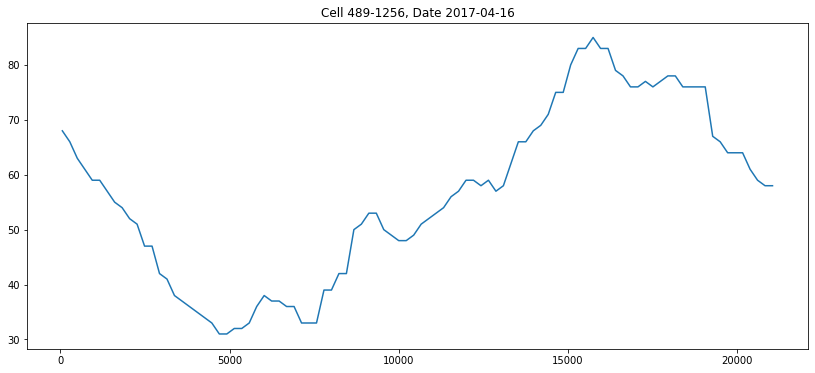

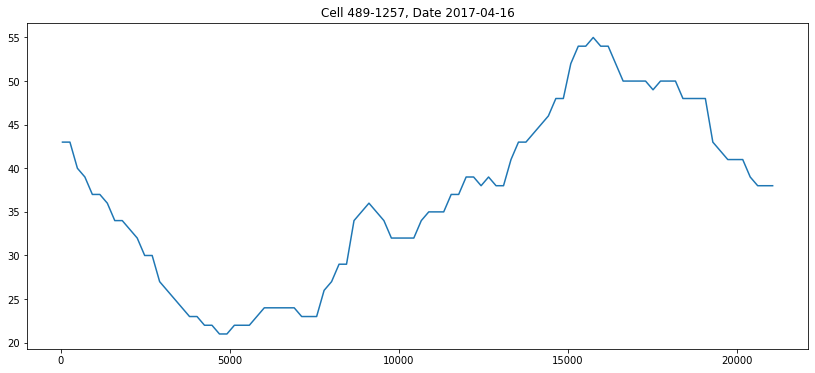

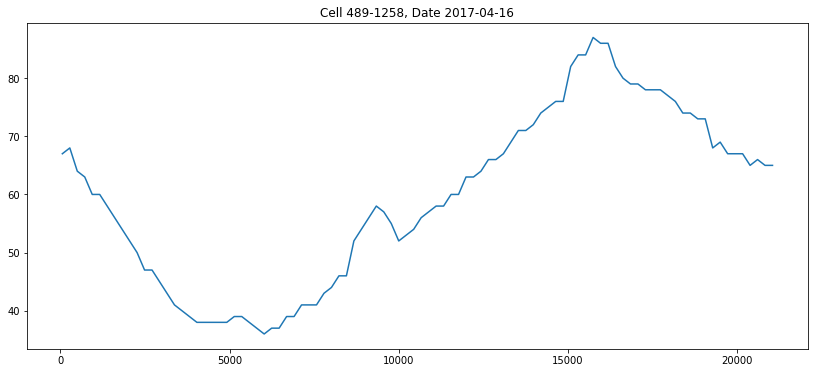

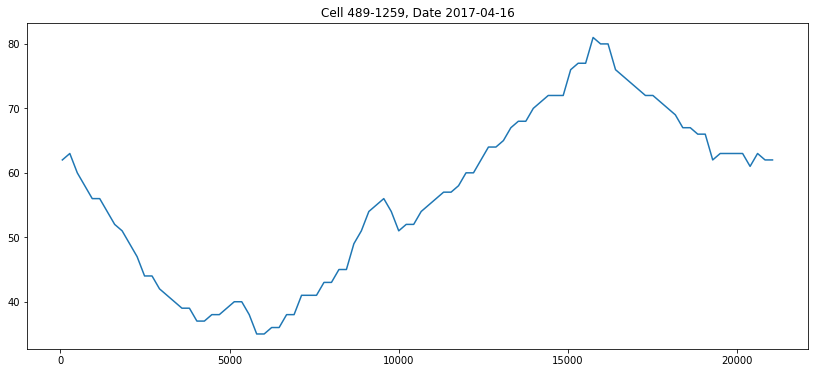

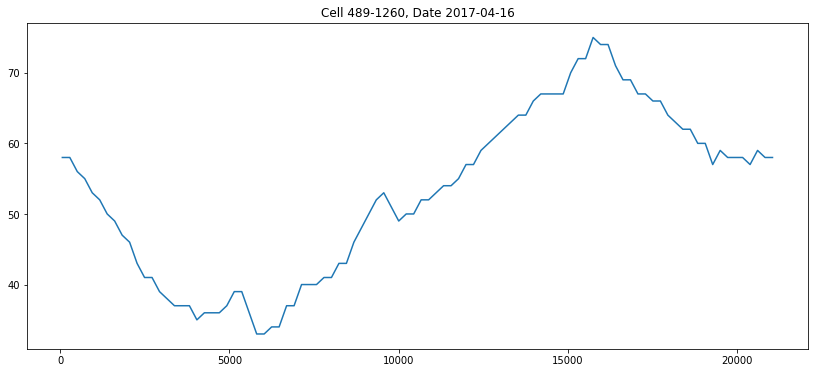

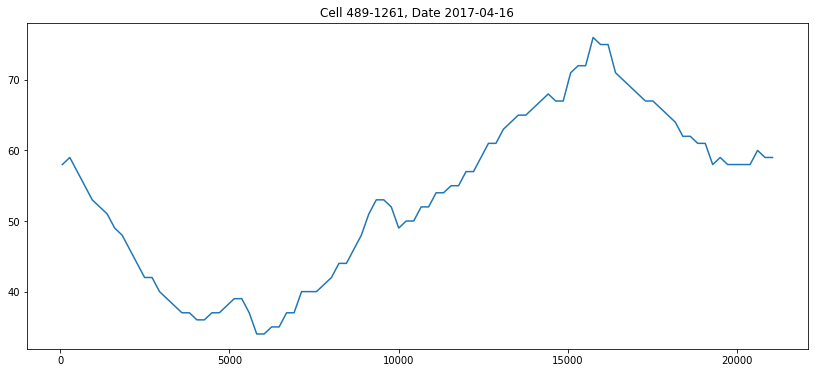

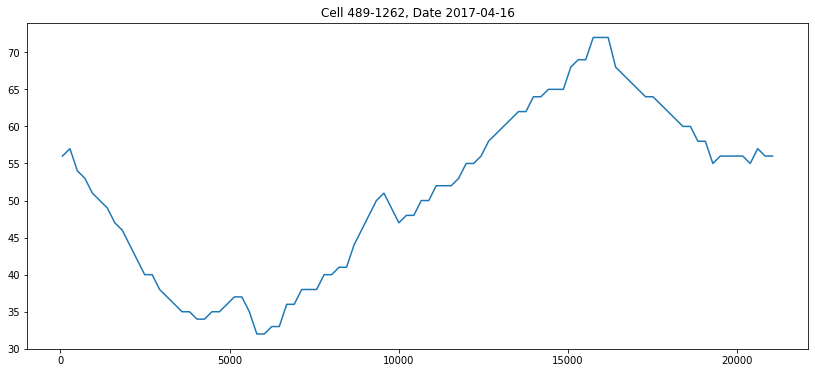

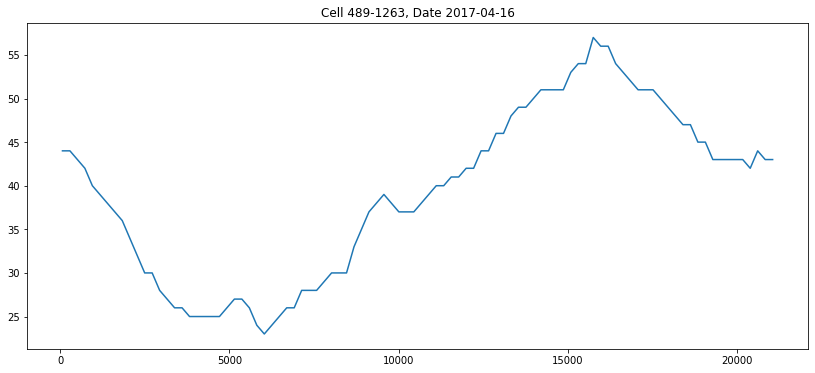

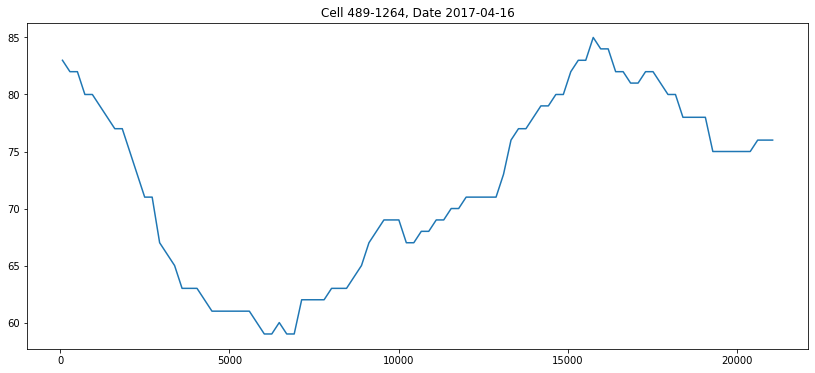

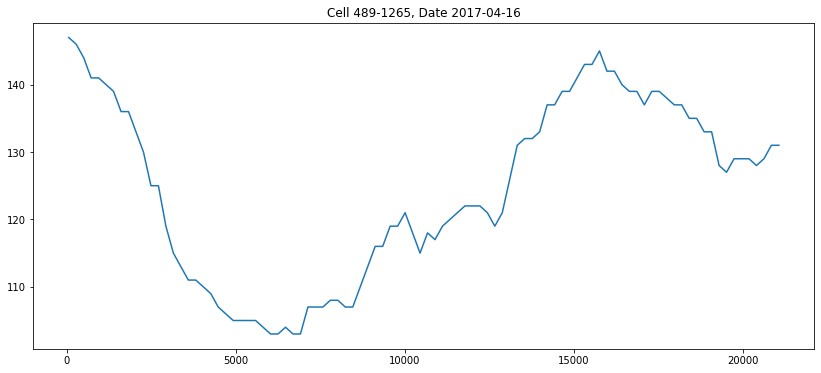

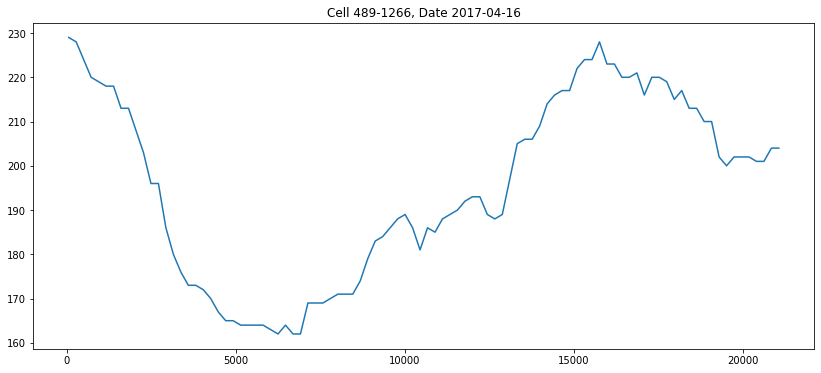

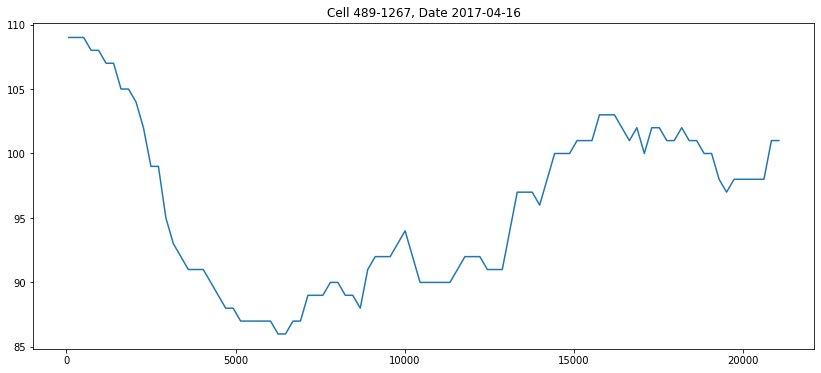

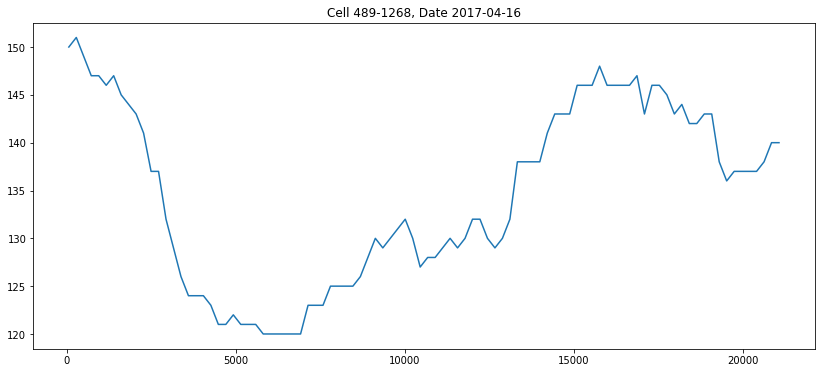

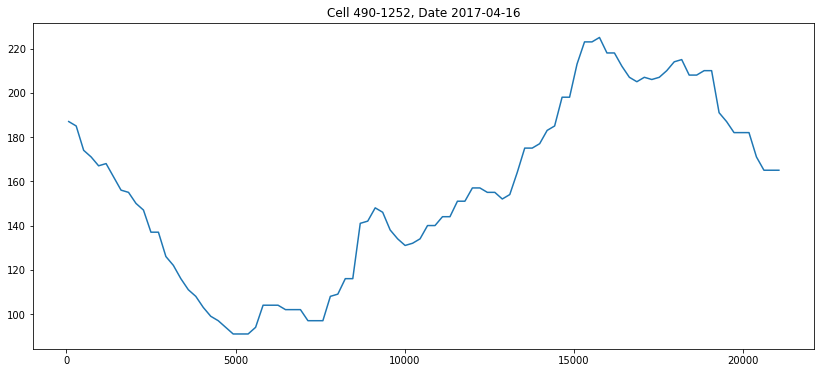

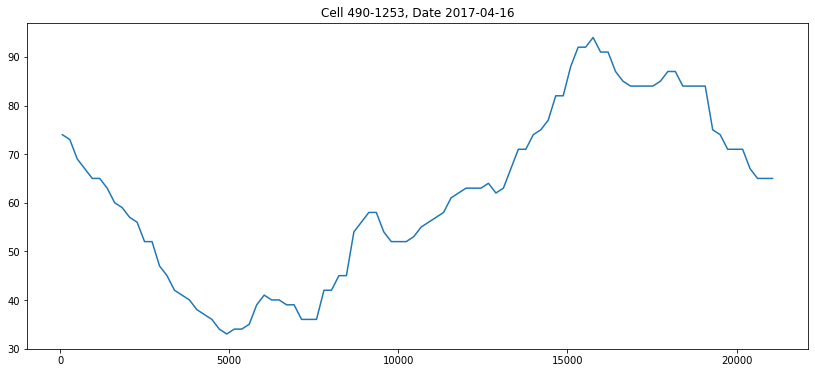

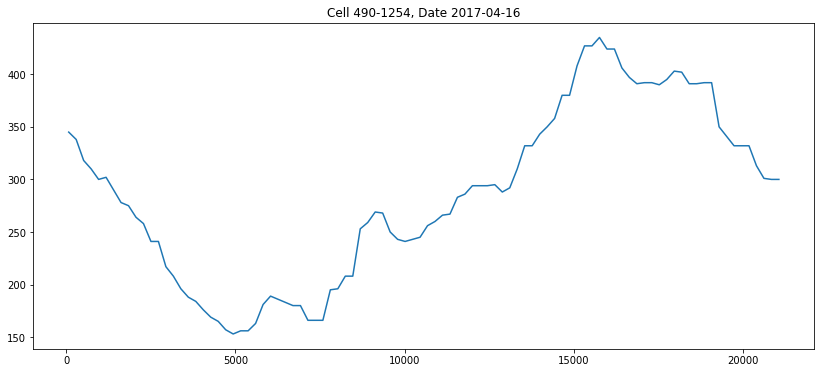

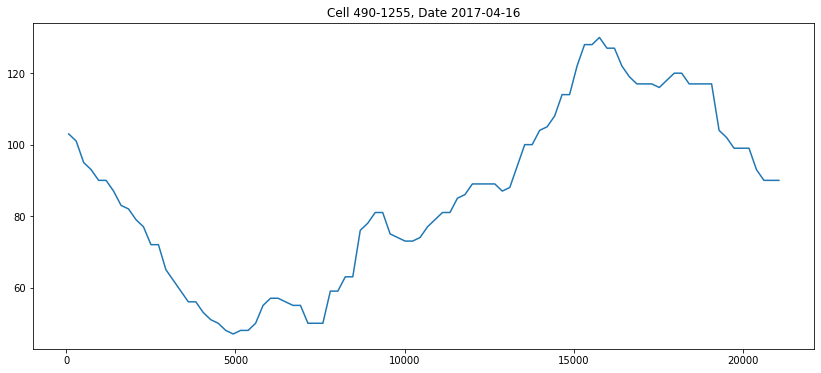

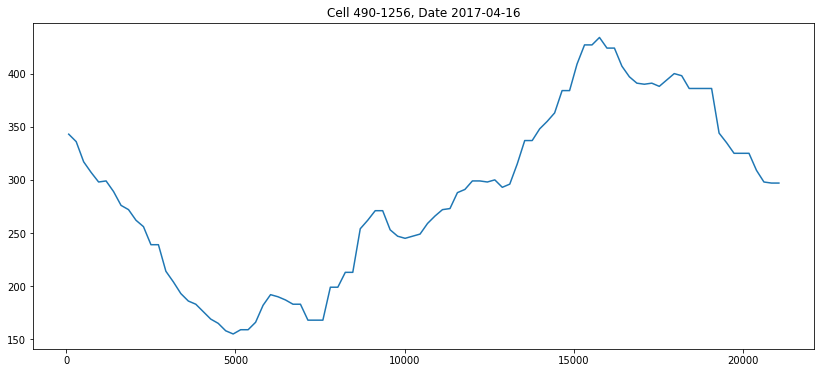

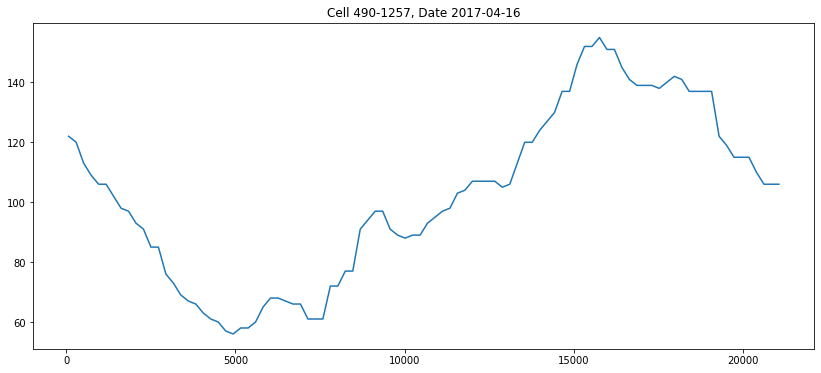

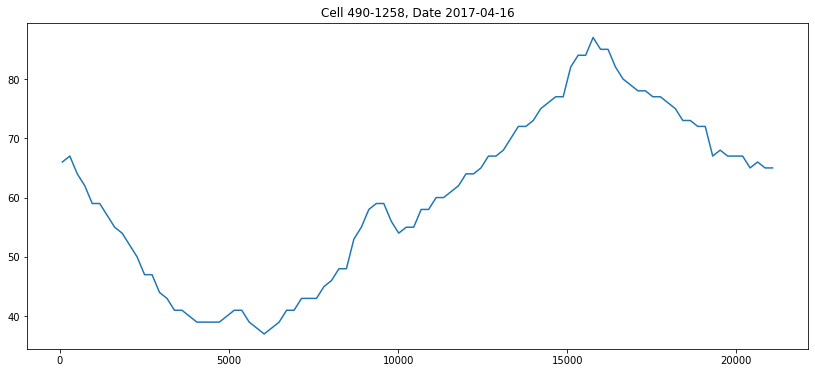

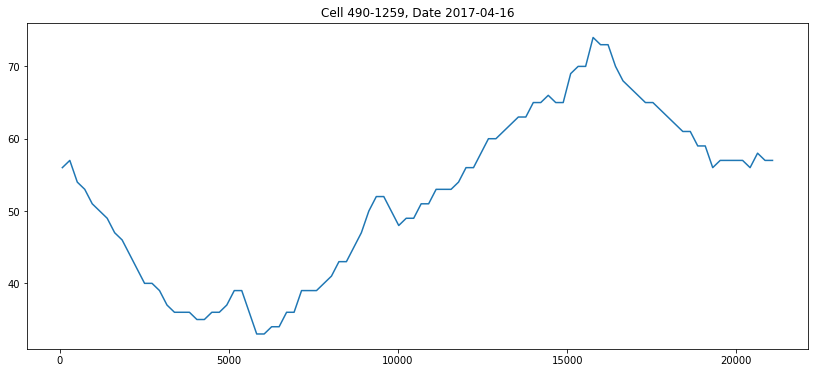

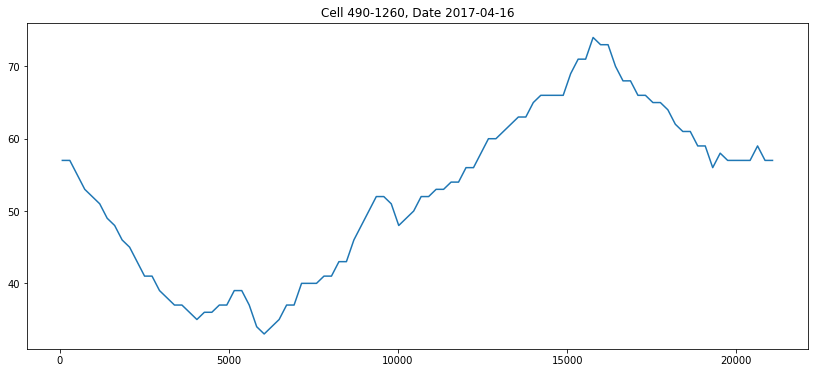

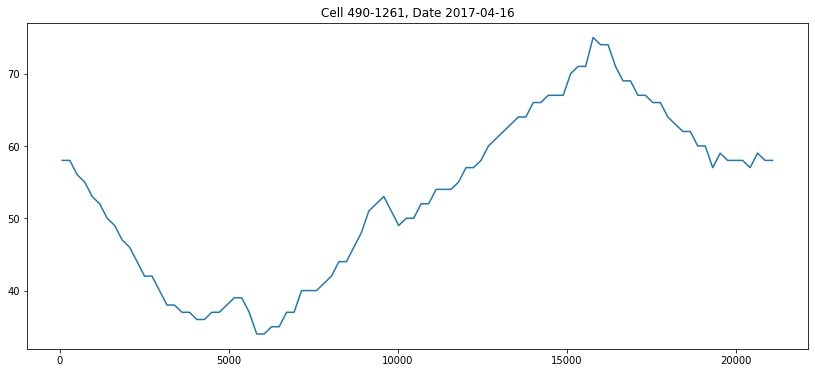

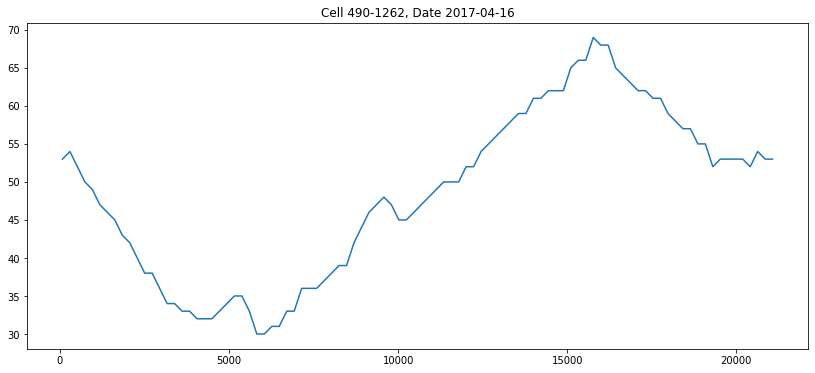

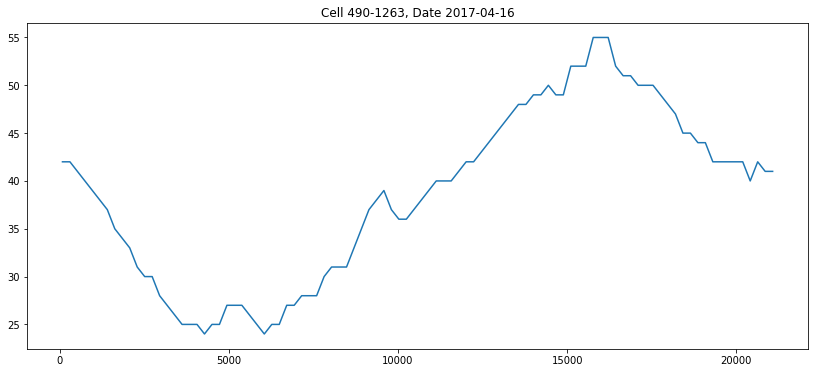

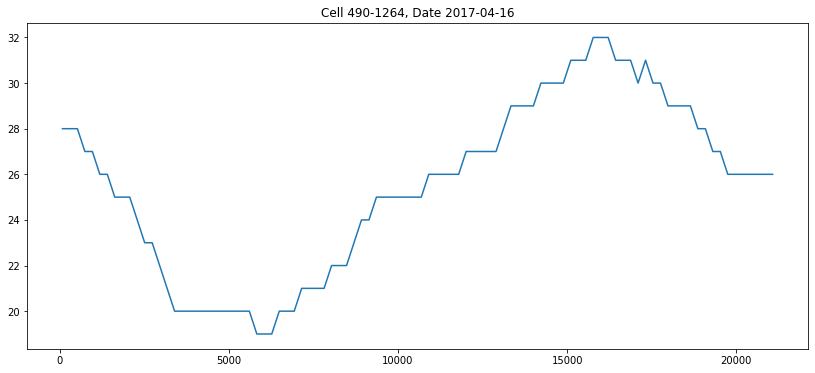

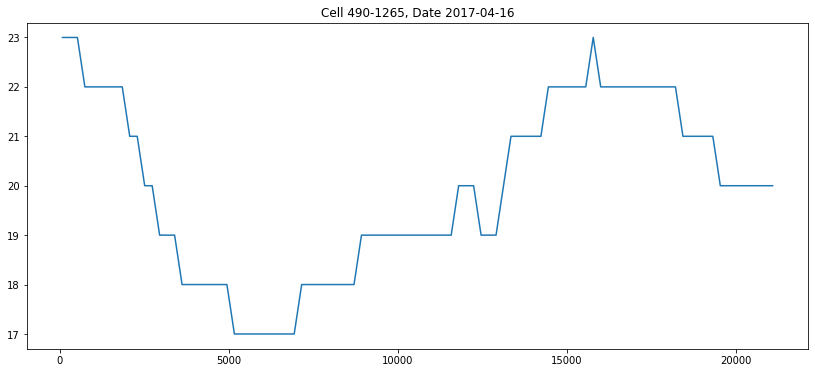

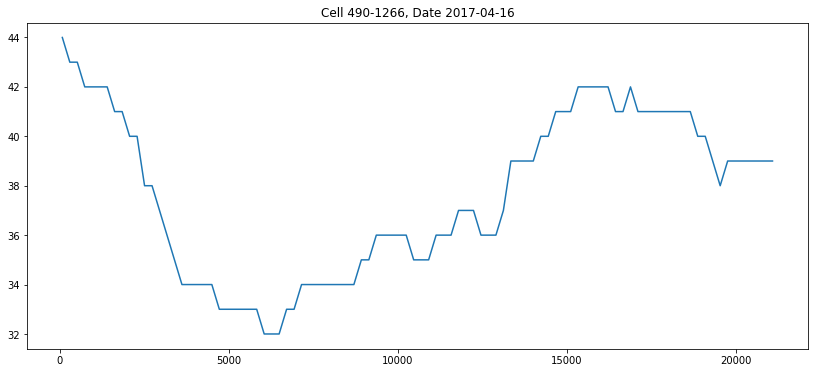

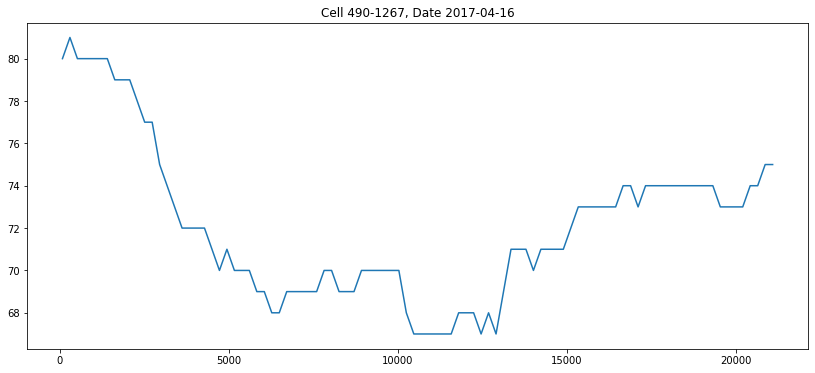

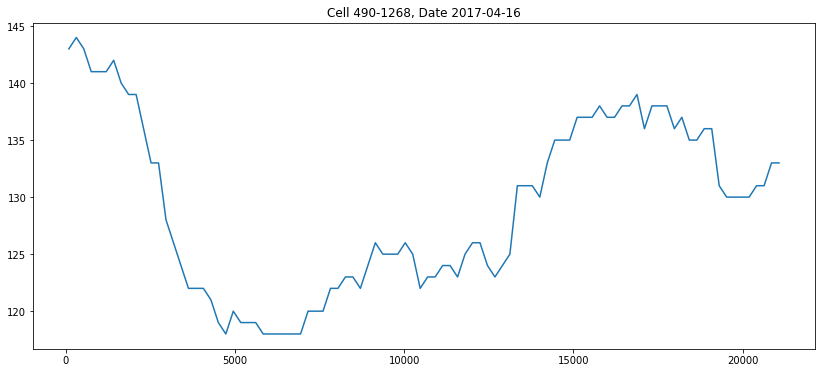

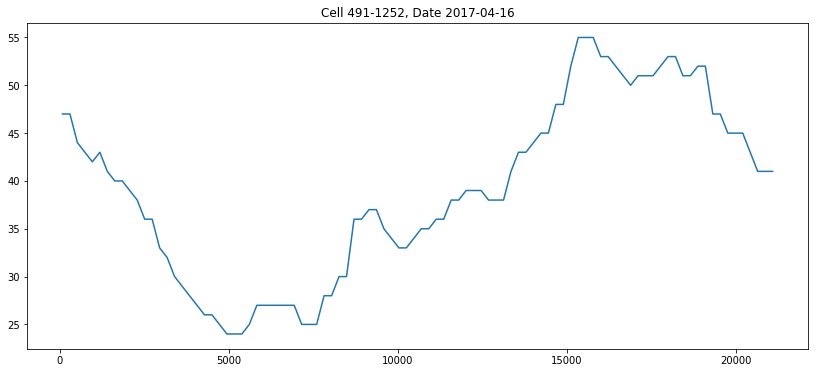

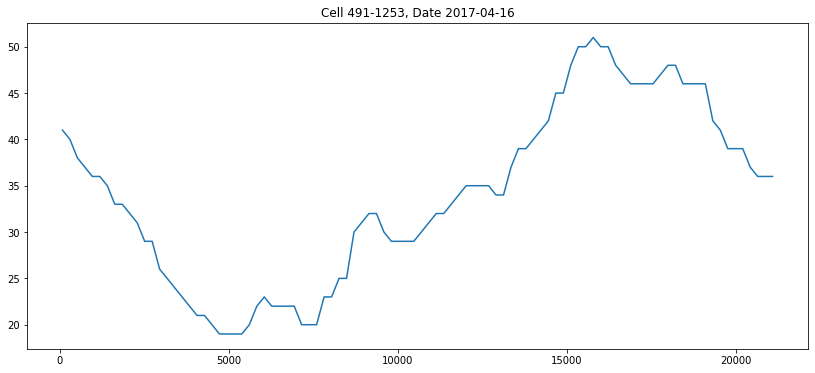

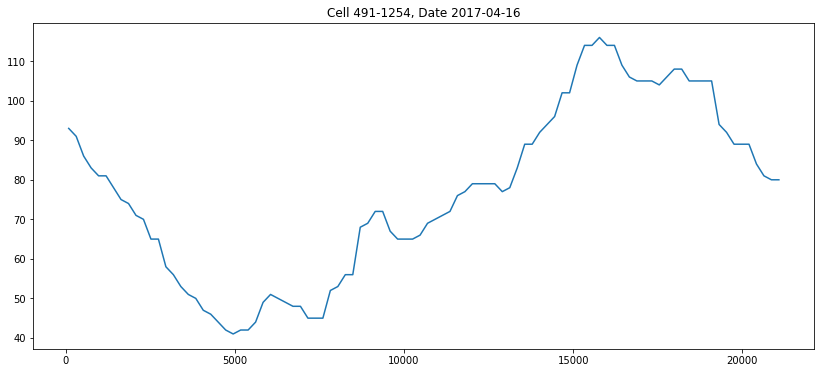

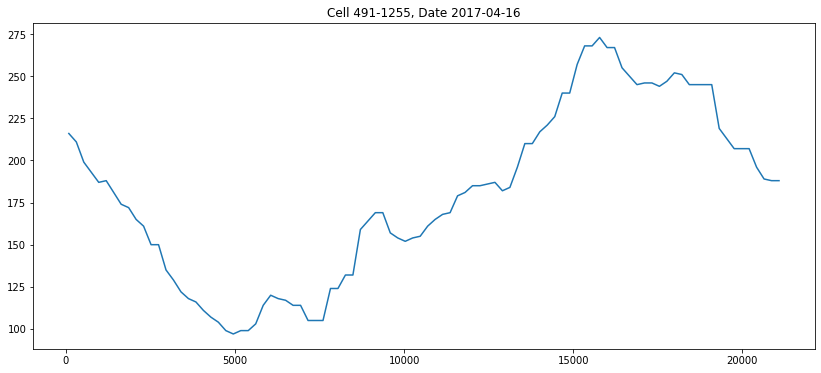

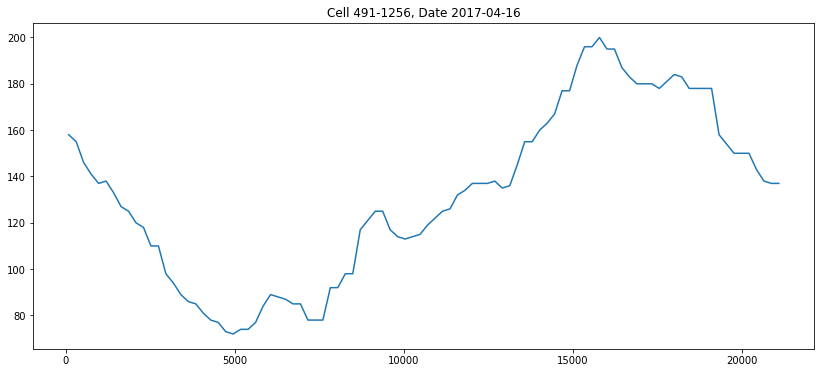

In [13]:
count = 0
for i, k in agg_by_date_cell:
    count +=1
    if count > 90:
        count = 0
        break
    k['nr_people'].plot(figsize = (14, 6), title='Cell '+str(i[1])+', Date '+str(i[0]));
    plt.show()
    

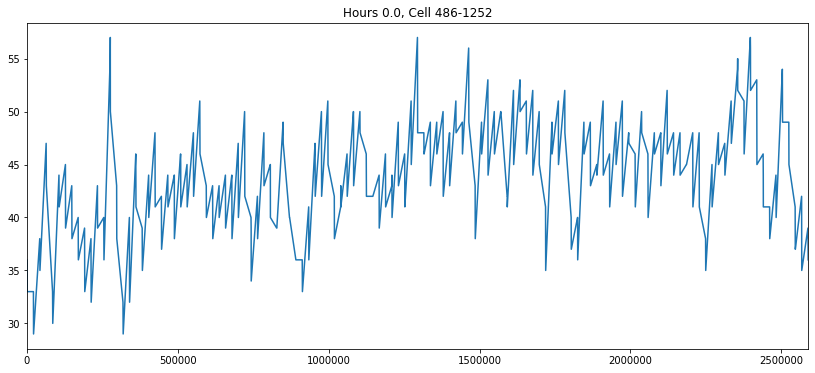

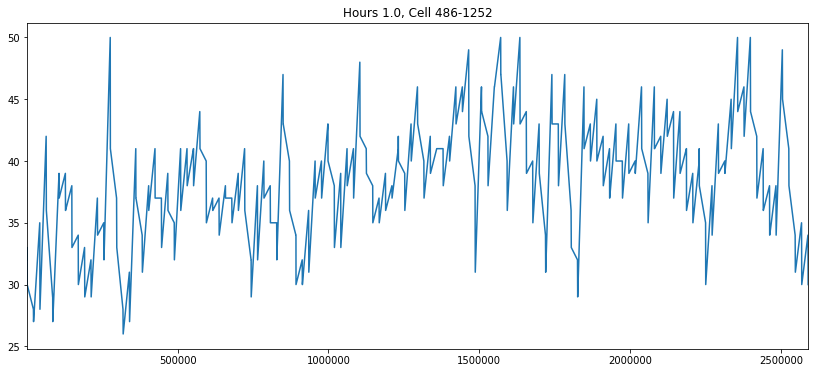

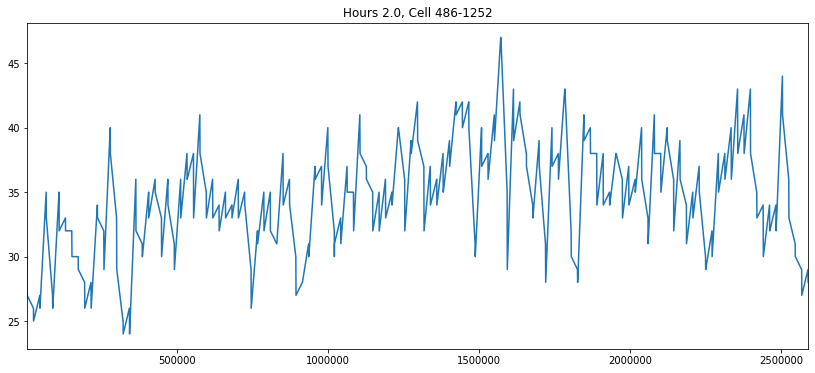

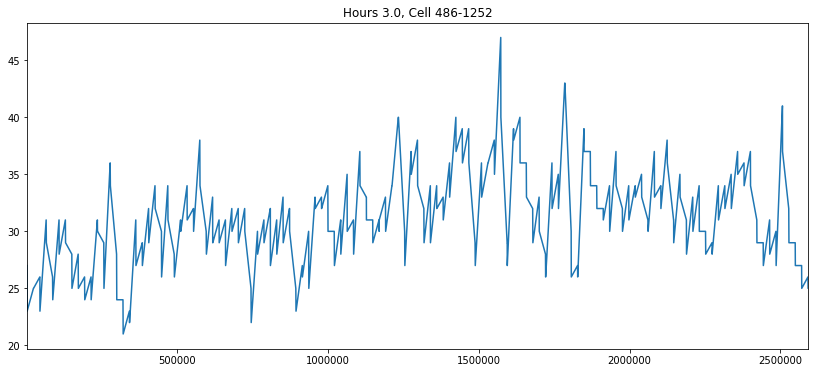

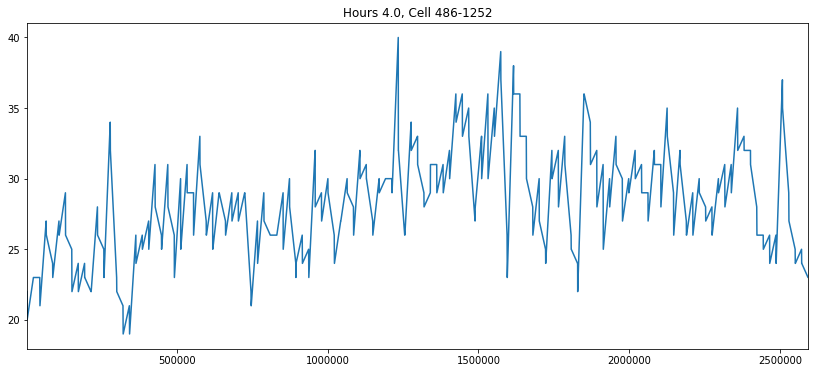

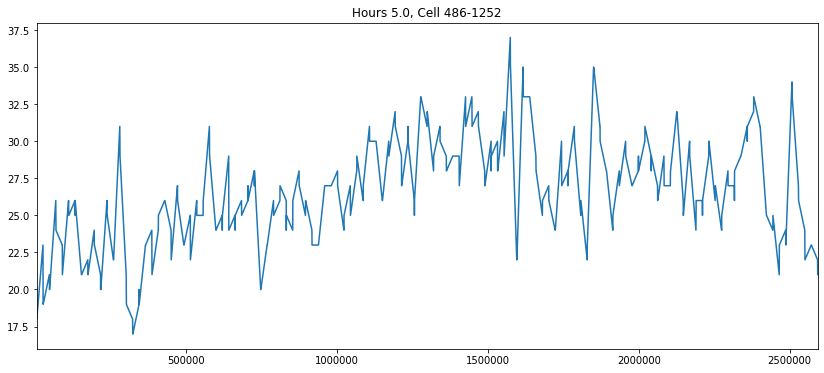

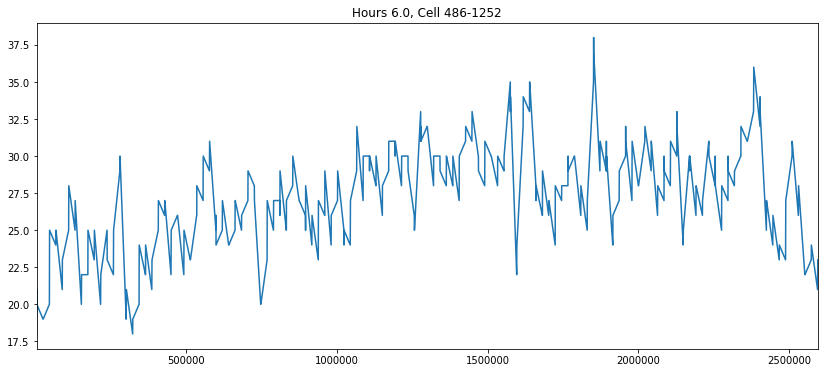

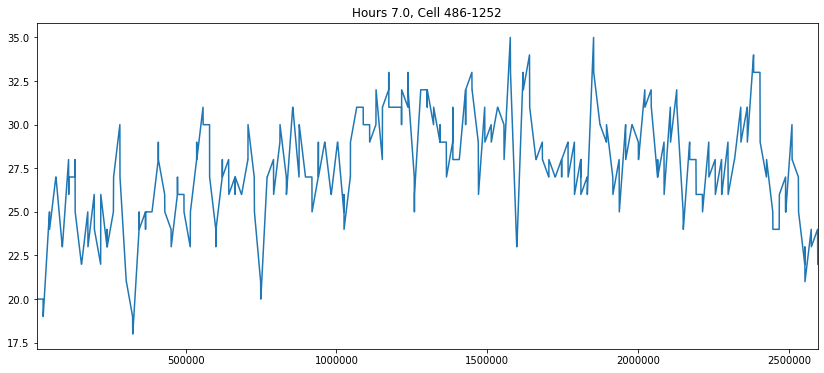

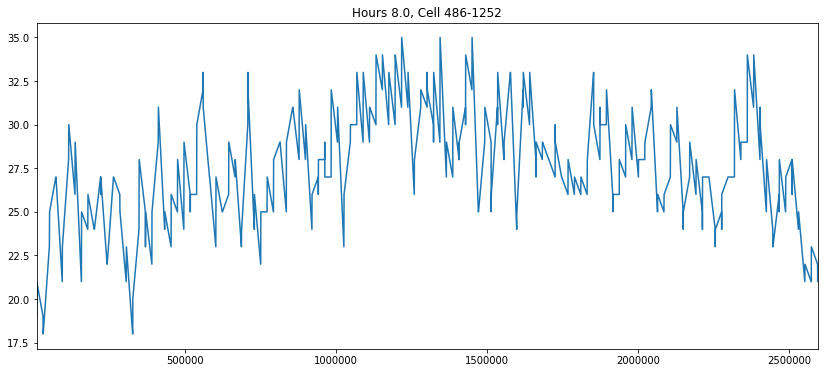

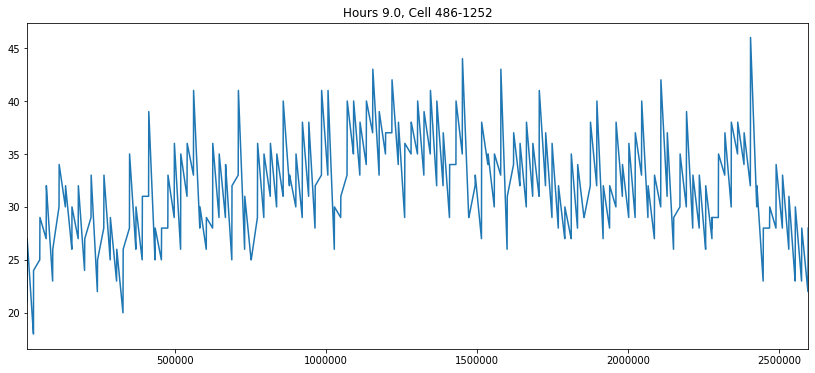

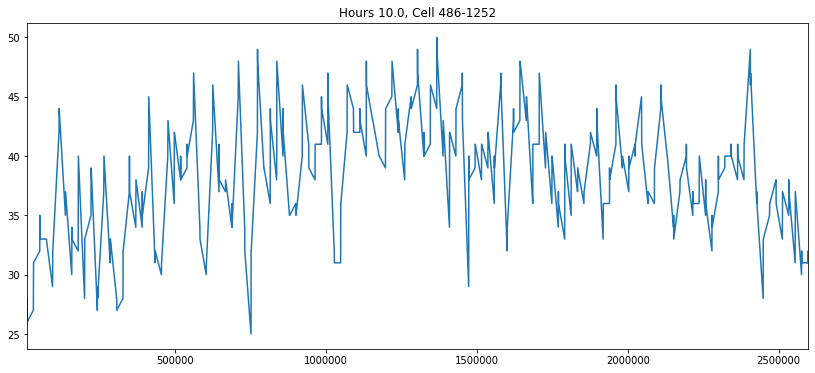

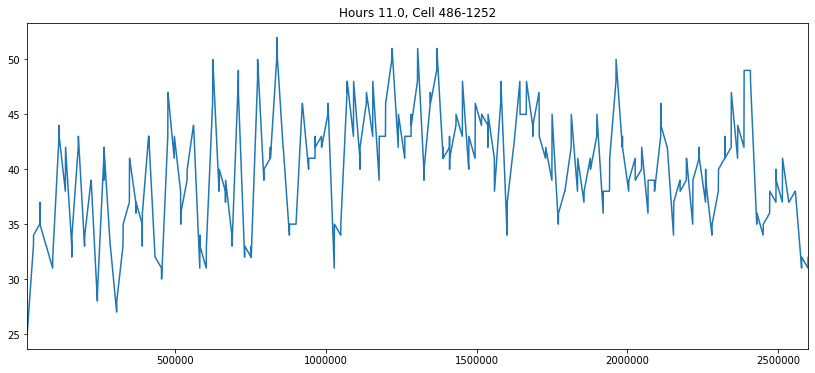

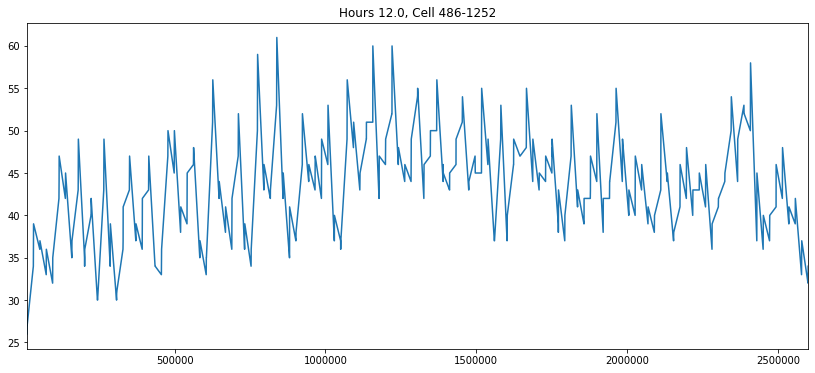

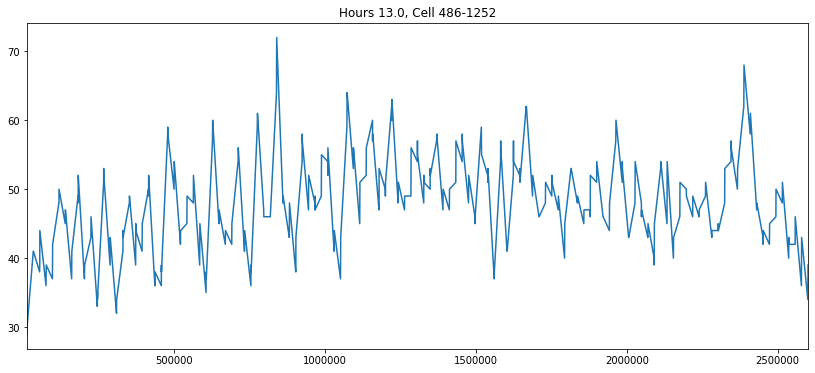

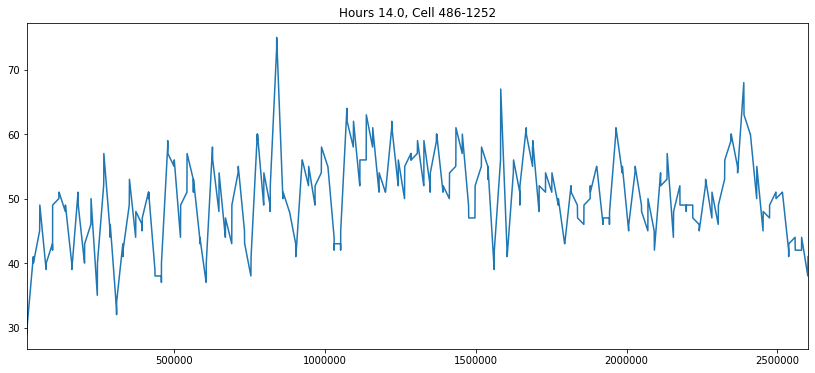

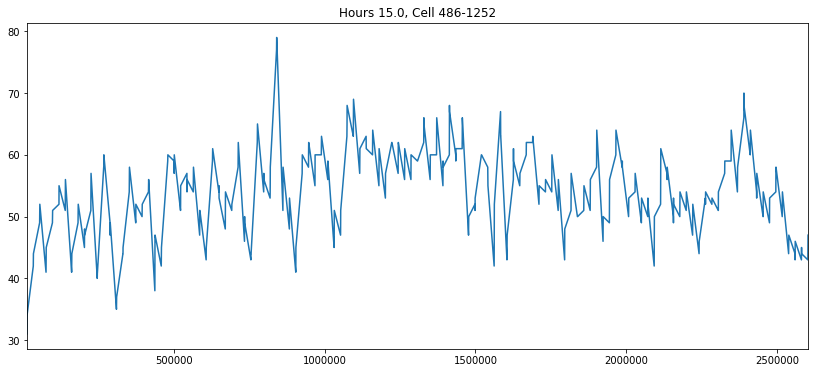

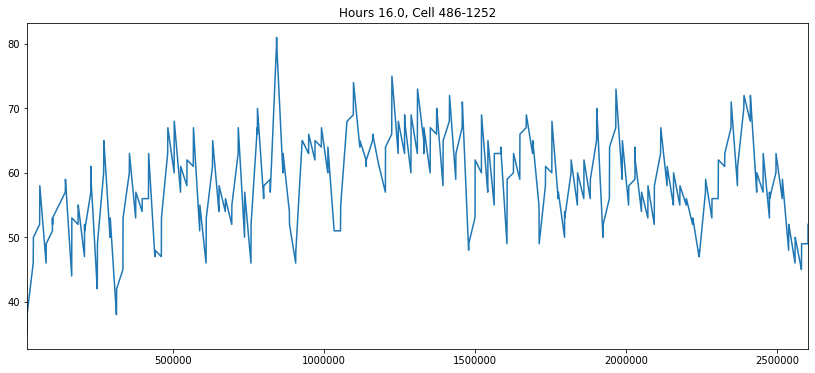

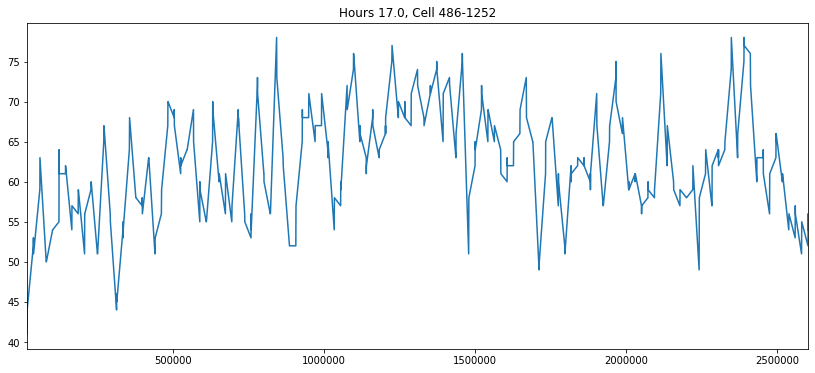

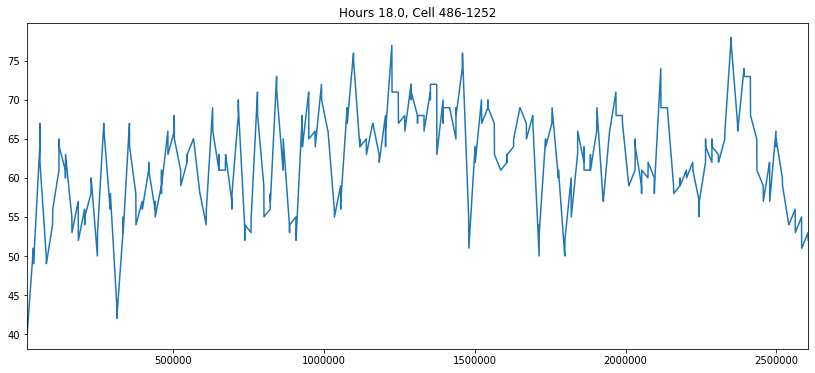

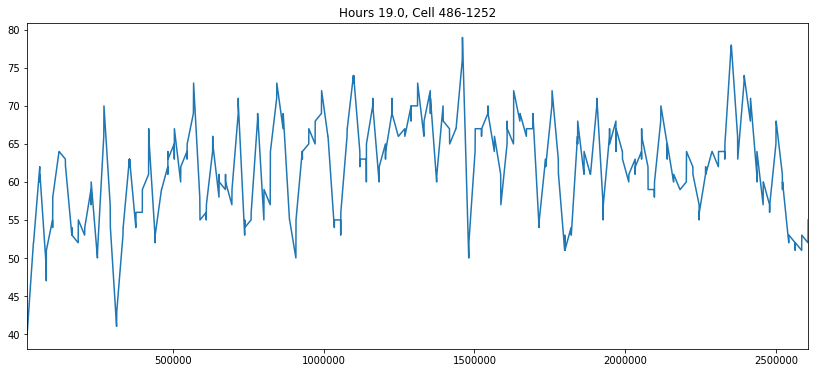

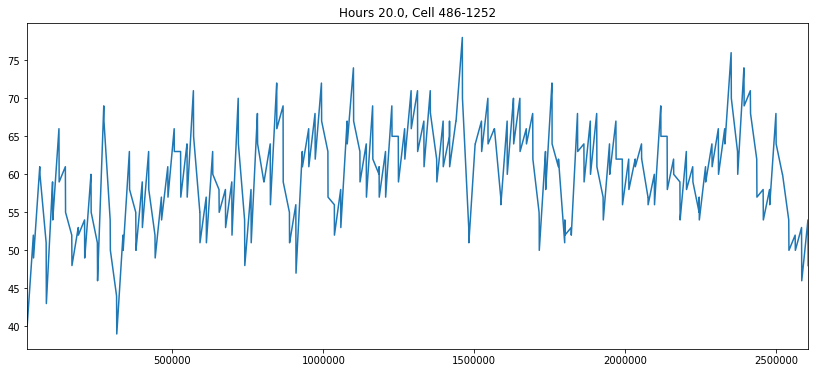

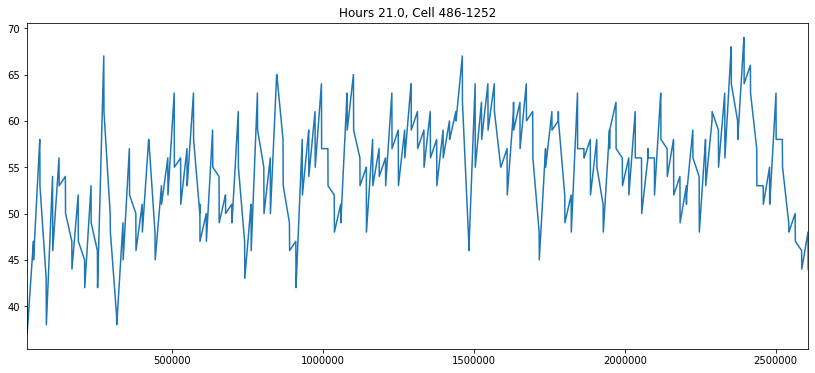

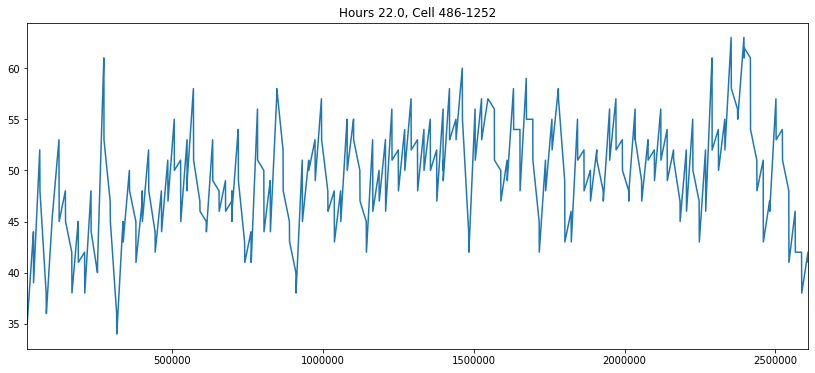

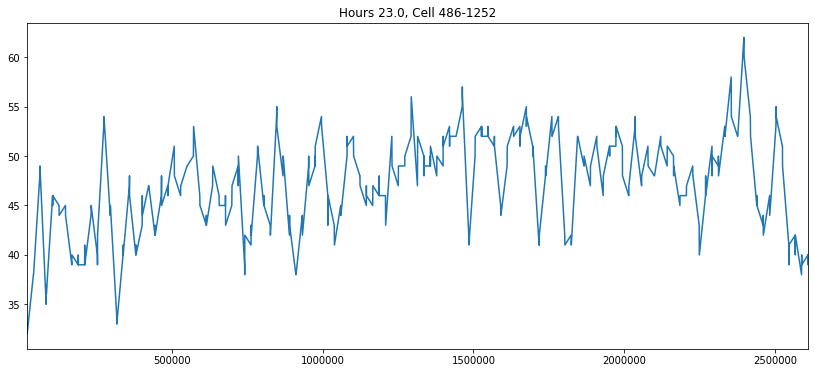

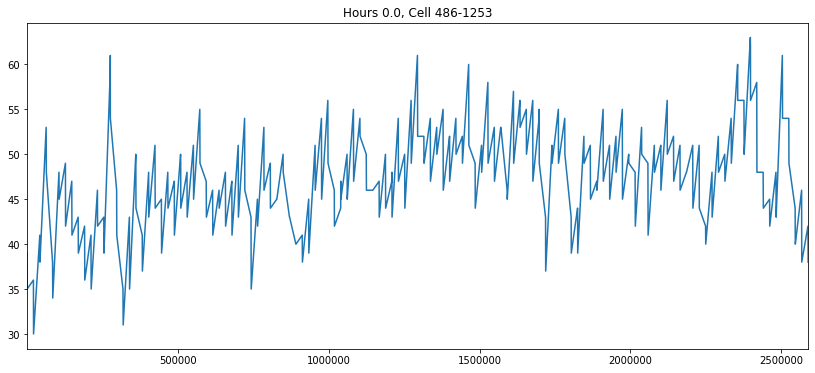

In [13]:
count = 0
for i, k in agg_by_cell_hour:
    count +=1
    k['nr_people'].plot(figsize = (14, 6), title='Hours '+str(i[1])+', Cell '+str(i[0]));
    plt.show()
    if count > 24:
        break
    

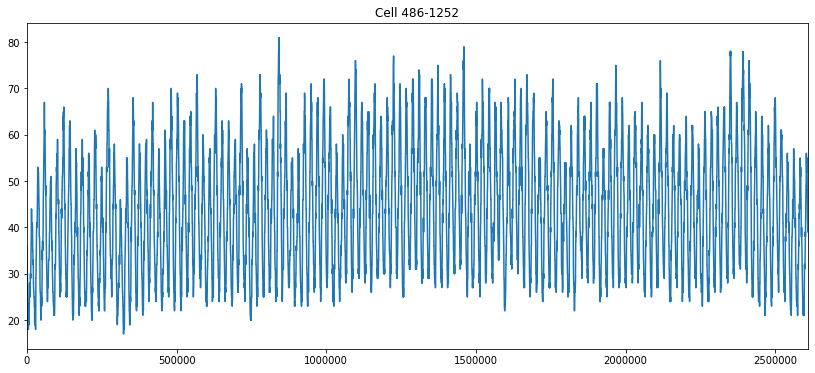

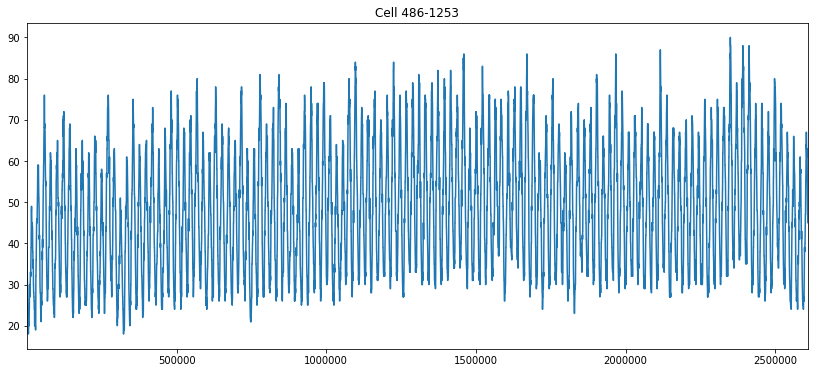

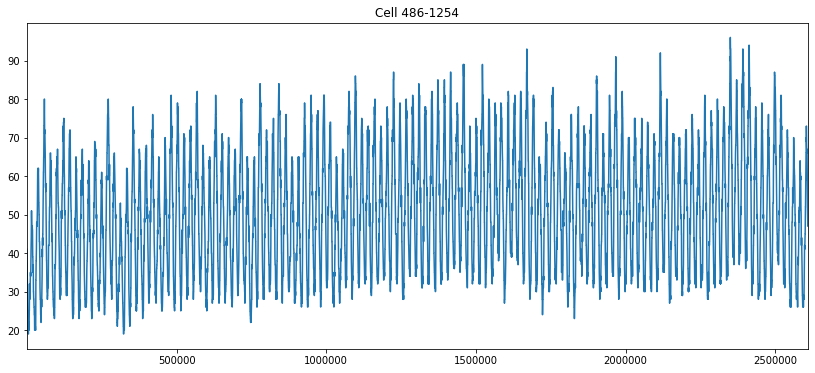

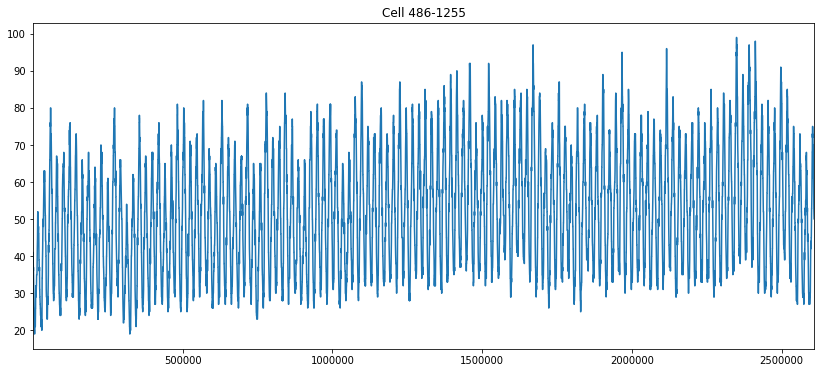

In [14]:
count = 0
for i, k in agg_by_cell:
    #print(i, k)
    count +=1
    k['nr_people'].plot(figsize = (14, 6), title='Cell '+str(i));
    plt.show()
    if count > 3:
        break

In [15]:
# crea una feature media 'mean' 
d_cell = {}
for i, k in agg_by_cell: 
    #print(i, k)
    d_cell[i] = int(k['nr_people'].mean())  
    
val = []

for i in data['cell_num']:
    val_i = d_cell.get(i)
    val.append(val_i)
        
data['mean']= val 
data 

date  cell_num  nr_people  hours  minutes  is_business_day  \
0        2017-04-16  486-1252       36.0    0.0      0.0                0   
221      2017-04-16  486-1252       36.0    0.0     15.0                0   
442      2017-04-16  486-1252       34.0    0.0     30.0                0   
663      2017-04-16  486-1252       33.0    0.0     45.0                0   
884      2017-04-16  486-1252       32.0    1.0      0.0                0   
...             ...       ...        ...    ...      ...              ...   
2608683  2017-08-16  498-1268       32.0   22.0     45.0                1   
2608904  2017-08-16  498-1268       32.0   23.0      0.0                1   
2609125  2017-08-16  498-1268       32.0   23.0     15.0                1   
2609346  2017-08-16  498-1268       32.0   23.0     30.0                1   
2609567  2017-08-16  498-1268       32.0   23.0     45.0                1   

         is_business_hour  mean  
0                       0    43  
221                     0    43  
442                     0    43  
663                     0    43  
884                     0    43  
...                   ...   ...  
2608683                 0    38  
2608904                 0    38  
2609125                 0    38  
2609346                 0    38  
2609567                 0    38  

[2609568 rows x 8 columns]

In [16]:
#data.to_csv('data_all_features.csv', index = False)

In [17]:
data = data[['date', 'cell_num', 'nr_people','hours', 'minutes', 'is_business_day','is_business_hour','mean']]
data

date  cell_num  nr_people  hours  minutes  is_business_day  \
0        2017-04-16  486-1252       36.0    0.0      0.0                0   
221      2017-04-16  486-1252       36.0    0.0     15.0                0   
442      2017-04-16  486-1252       34.0    0.0     30.0                0   
663      2017-04-16  486-1252       33.0    0.0     45.0                0   
884      2017-04-16  486-1252       32.0    1.0      0.0                0   
...             ...       ...        ...    ...      ...              ...   
2608683  2017-08-16  498-1268       32.0   22.0     45.0                1   
2608904  2017-08-16  498-1268       32.0   23.0      0.0                1   
2609125  2017-08-16  498-1268       32.0   23.0     15.0                1   
2609346  2017-08-16  498-1268       32.0   23.0     30.0                1   
2609567  2017-08-16  498-1268       32.0   23.0     45.0                1   

         is_business_hour  mean  
0                       0    43  
221                     0    43  
442                     0    43  
663                     0    43  
884                     0    43  
...                   ...   ...  
2608683                 0    38  
2608904                 0    38  
2609125                 0    38  
2609346                 0    38  
2609567                 0    38  

[2609568 rows x 8 columns]

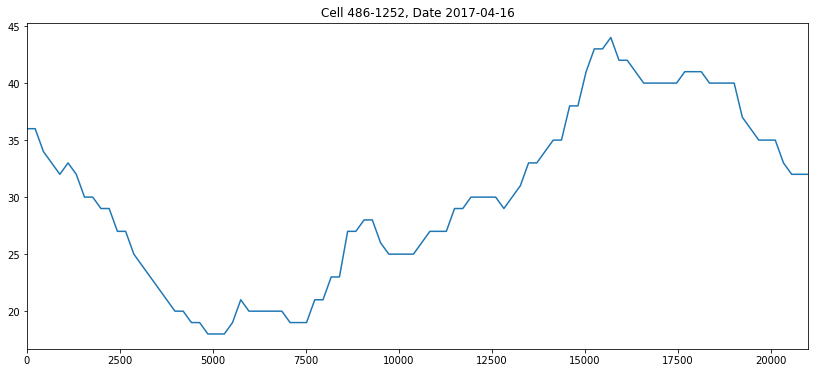

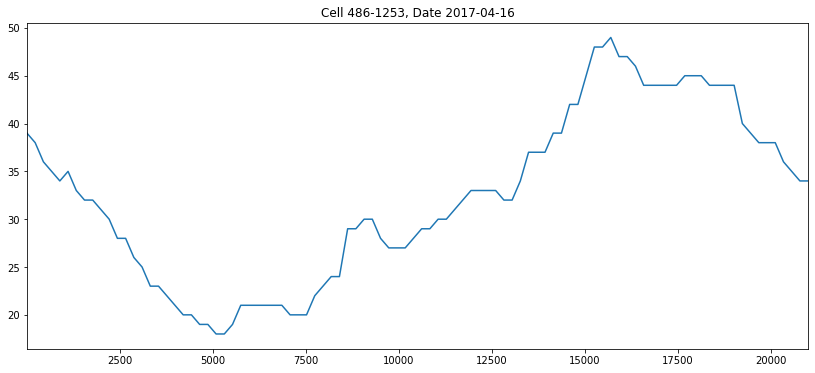

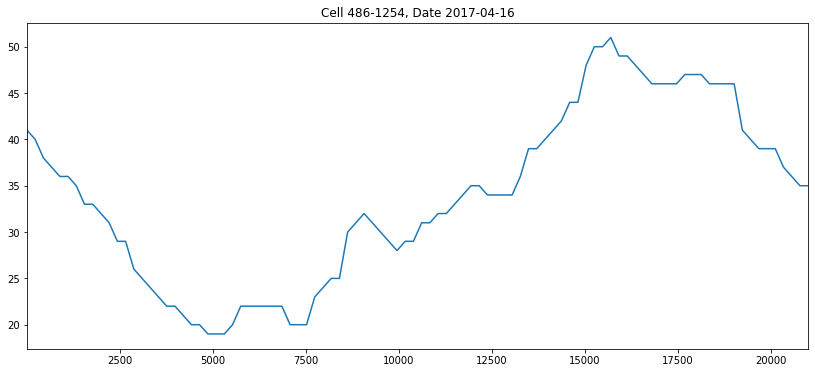

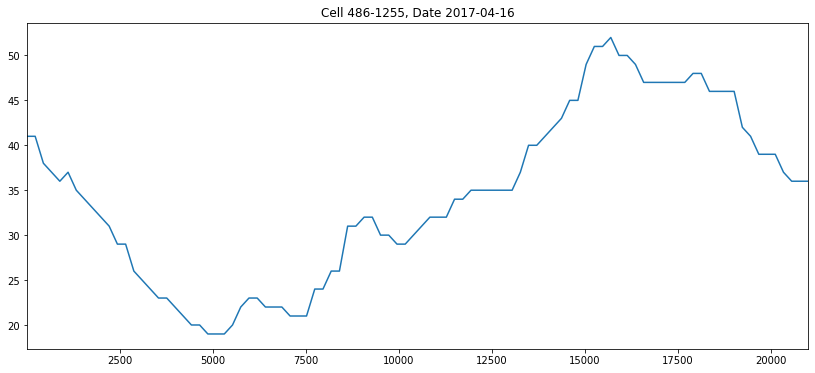

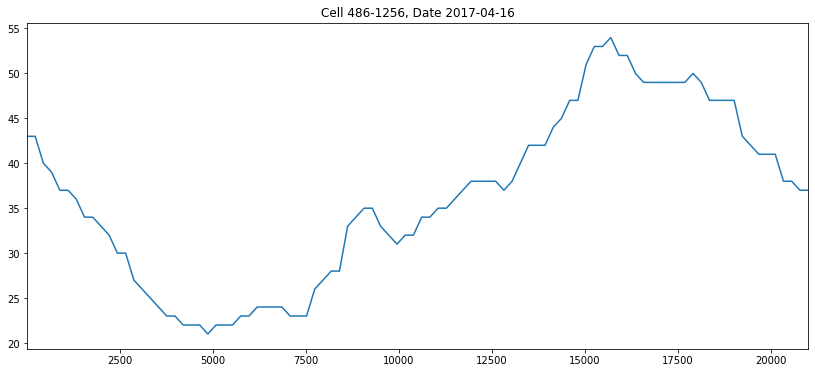

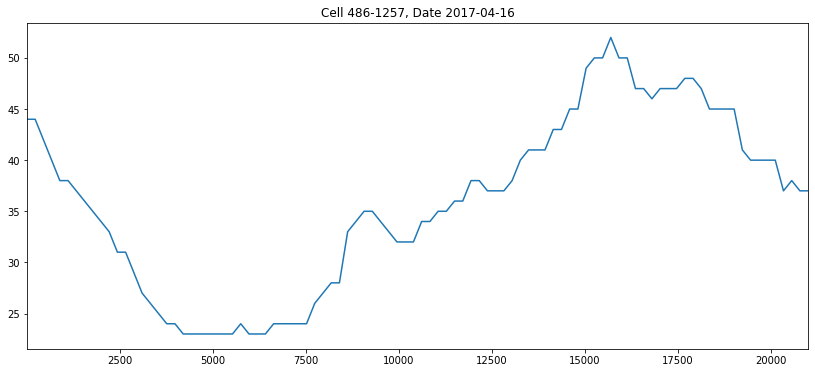

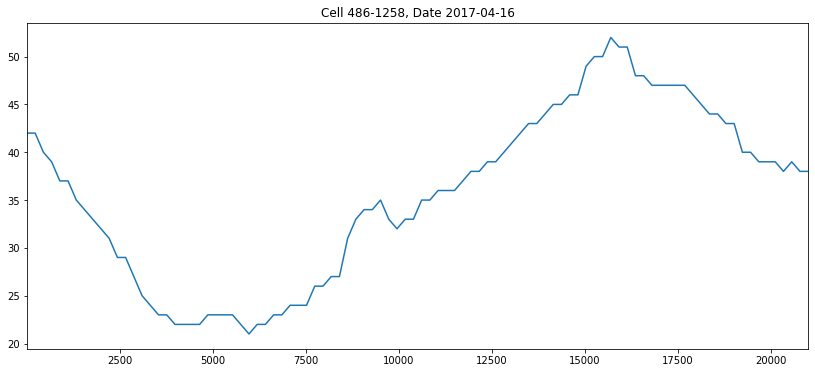

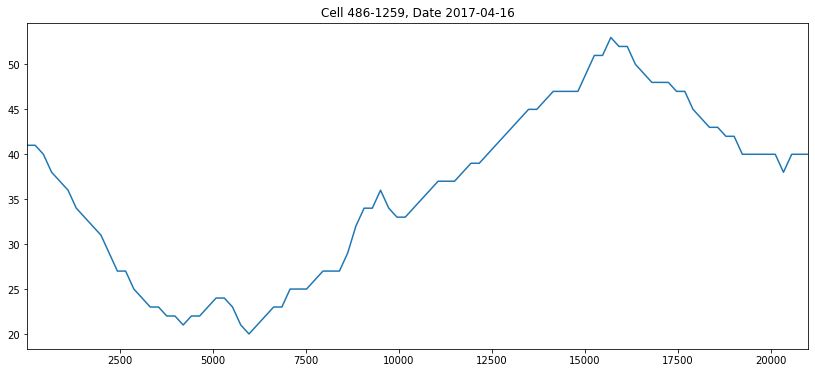

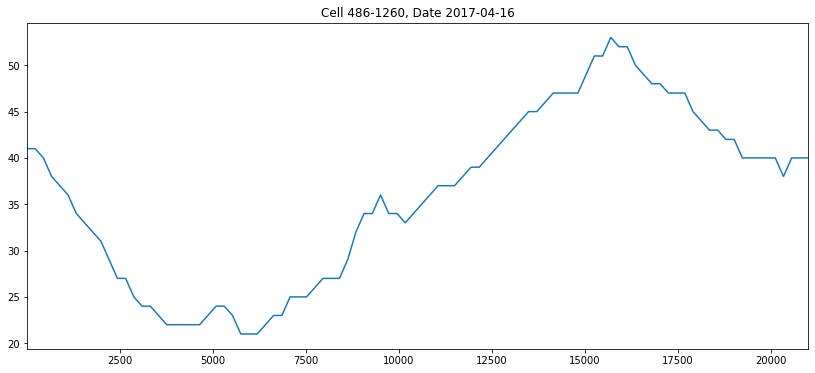

In [18]:
agg_by_date_cell = data.groupby(['date', 'cell_num'])
count = 0
for i, k in agg_by_date_cell:
    count +=1
    if count > 9:
        count = 0
        break
    k['nr_people'].plot(figsize = (14, 6), title='Cell '+str(i[1])+', Date '+str(i[0]));
    plt.show()

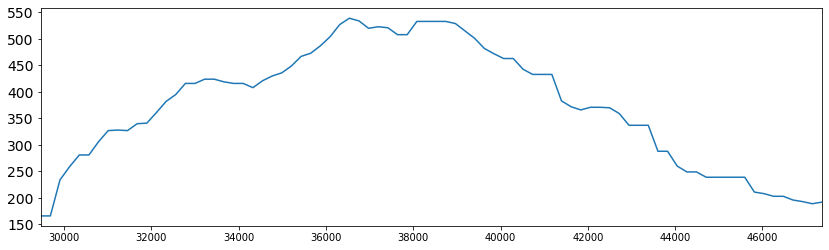

In [19]:
agg_by_cell = data.groupby(['cell_num'])
cell_i = agg_by_cell.get_group('490-1254')
plt.yticks(fontsize=14)
cell_i['nr_people'][133:215].plot(figsize = (14, 4))
plt.show()


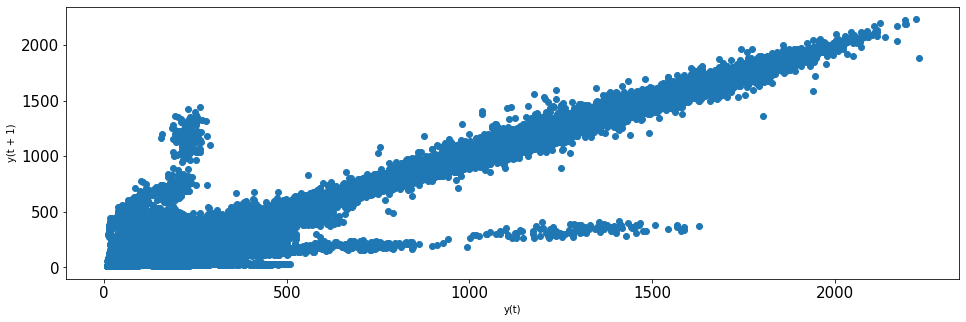

In [24]:
plt.figure(figsize=(16,5))

lag_plot(data['nr_people'])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show();

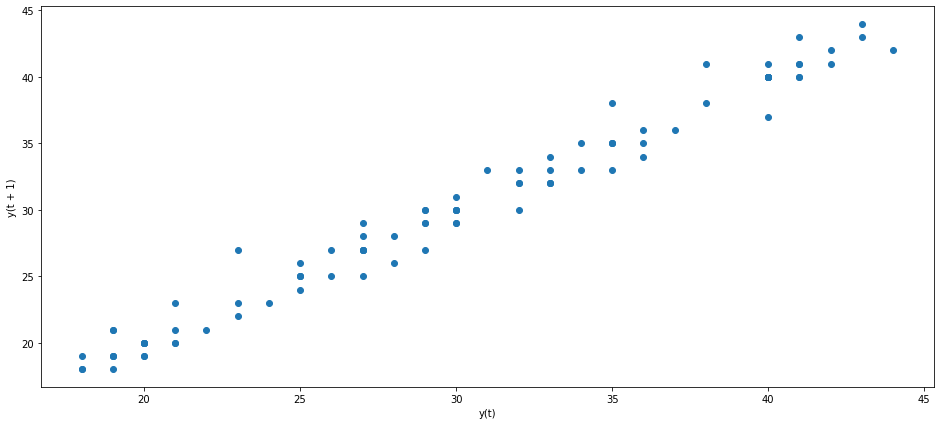

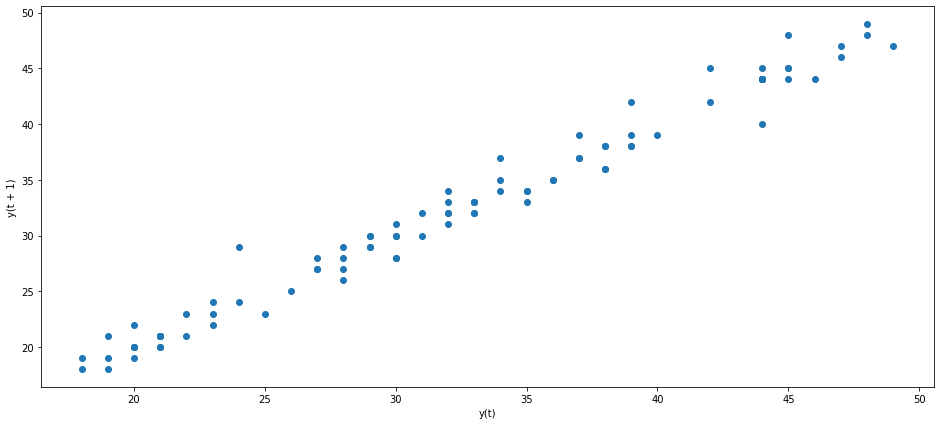

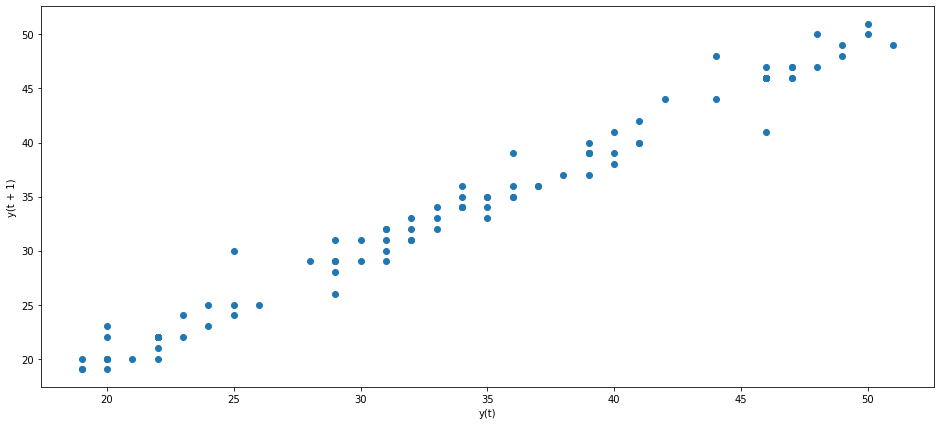

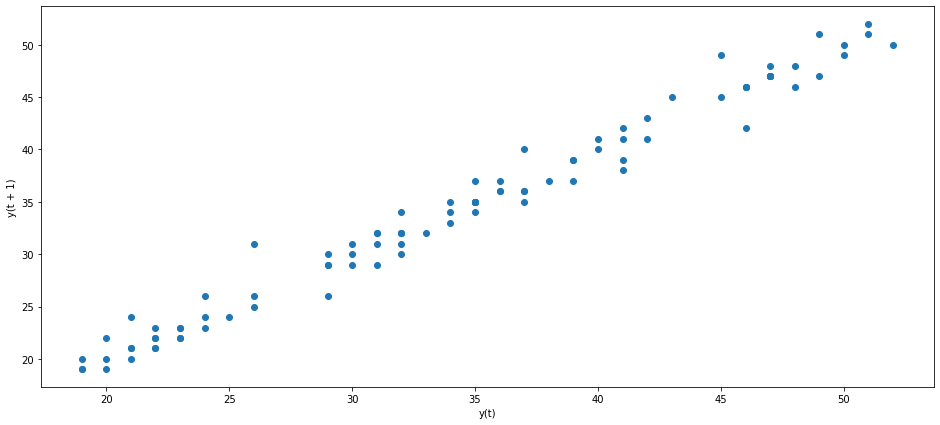

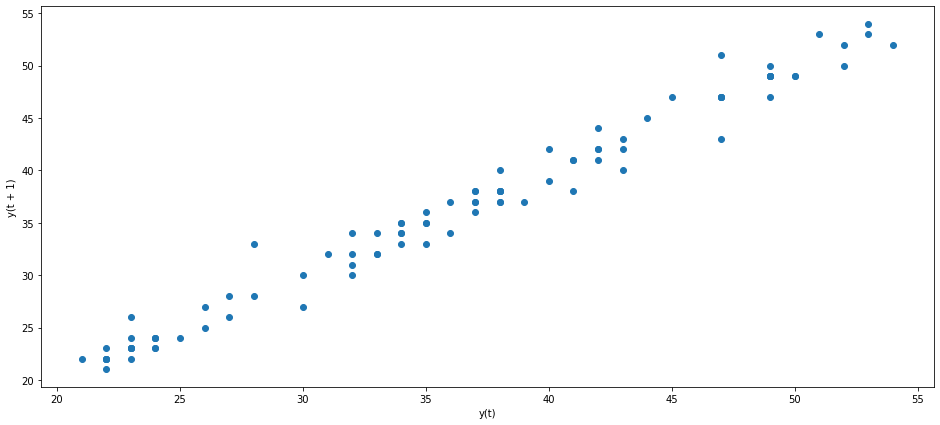

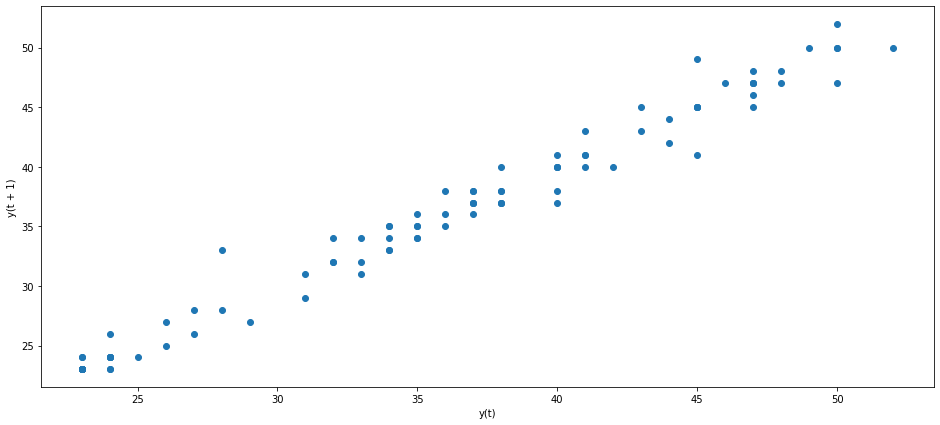

In [19]:
agg_date_cell = data.groupby(by = ['date', 'cell_num'])
count = 0
for i, k in agg_date_cell: 
    #print(i, k)
    plt.figure(figsize=(16,7))
    lag_plot(k['nr_people'])
    plt.show();
    count +=1
    if count > 5:
        break

### Visualizzazione Griglia dati

In [20]:
geo_df = gpd.read_file('/Users/alket/Desktop/dati/shp/BLQ.shp')
geo_df.head(10)

SP_ID  val                                           geometry
0  487-1253  0.0  POLYGON ((11.28333 44.53417, 11.28333 44.53542...
1  487-1254  0.0  POLYGON ((11.28500 44.53417, 11.28500 44.53542...
2  487-1255  0.0  POLYGON ((11.28667 44.53417, 11.28667 44.53542...
3  487-1256  0.0  POLYGON ((11.28833 44.53417, 11.28833 44.53542...
4  487-1257  0.0  POLYGON ((11.29000 44.53417, 11.29000 44.53542...
5  487-1258  0.0  POLYGON ((11.29167 44.53417, 11.29167 44.53542...
6  487-1259  0.0  POLYGON ((11.29333 44.53417, 11.29333 44.53542...
7  487-1260  0.0  POLYGON ((11.29500 44.53417, 11.29500 44.53542...
8  487-1261  0.0  POLYGON ((11.29667 44.53417, 11.29667 44.53542...
9  487-1262  0.0  POLYGON ((11.29833 44.53417, 11.29833 44.53542...

In [21]:
locations_2 = []
loc_in = []
loc = []

for i in geo_df.geometry:
    #print(i)
    stringa = str(i)
    coord = stringa[10:]
    coord = coord[:-2]
    #print(coord)
    co1 = coord.split(',')
    for j in co1:
        j = j.strip()
        co_0 = j.split(' ')
        #print(co_0)
        loc_in.append(float(co_0[1].strip()))
        loc_in.append(float(co_0[0].strip()))
        loc.append(loc_in)
        loc_in = []
    locations_2.append(loc)
    loc = []
    
print(len(locations_2) )

221


In [22]:
data2 = data.sample(n = 221)
data2

date  cell_num  nr_people  hours  minutes  is_business_day  \
2199083  2017-07-28  493-1266       23.0   15.0     30.0                1   
1320491  2017-06-17  486-1268       21.0    5.0     45.0                0   
1481137  2017-06-24  498-1264       20.0   19.0     15.0                0   
1220637  2017-06-12  489-1255      299.0   12.0     45.0                1   
1076105  2017-06-05  489-1257       86.0   17.0     15.0                1   
...             ...       ...        ...    ...      ...              ...   
756667   2017-05-21  496-1266       20.0   15.0     45.0                0   
1923270  2017-07-15  493-1261      194.0   15.0     30.0                0   
1567737  2017-06-28  496-1266       25.0   21.0     15.0                1   
1878098  2017-07-13  488-1258       71.0   12.0     30.0                1   
1317531  2017-06-17  494-1266       21.0    2.0     15.0                0   

         is_business_hour  mean  
2199083                 1    22  
1320491                 0    26  
1481137                 1    18  
1220637                 1   213  
1076105                 1    51  
...                   ...   ...  
756667                  1    20  
1923270                 1   186  
1567737                 0    20  
1878098                 1    70  
1317531                 0    19  

[221 rows x 8 columns]

In [23]:
cells = geo_df['SP_ID'].tolist()
print(len(cells))

mean2cell = data2['mean'].tolist()
minn = min(mean2cell)
print(minn)
maxx = max(mean2cell)
print(maxx)
normalized = []

count = 0
for i in mean2cell: 
    #print(type(i)) 
    #count +=1
    try:
        rounded = round((i-minn)/(maxx-minn),3)
        normalized.append(rounded)
    except ZeroDivisionError:
        normalized.append(0)
                      
normalized[0:10] 

221
12
1213


[0.008, 0.012, 0.005, 0.167, 0.032, 0.021, 0.09, 0.005, 0.006, 0.126]

In [24]:
print(len(cells), ' > ', len(normalized))

221  >  221


In [25]:
air = folium.Map(location = [44.52492,11.300016], zoom_start=15)
#print(locations_2[0])
count = 0
count_norm = 0
for i in locations_2:
    folium.Polygon(locations = locations_2[count], color='blue', weight=1, fill_color='red', 
                   fill_opacity=normalized[count_norm]-0.1,fill=True, popup='Aeroporto',
                   tooltip='Cell = '+cells[count]+' norm.act = '+str(normalized[count_norm]),
    ).add_to(air)
    
    count +=1
    count_norm +=1
display(air)